In [25]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import jellyfish
import os
import shutil
import subprocess
import requests
from github import Github
from git import Repo
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import configparser
import h2o
import scipy as sp

## Result Gathering

In [26]:
main_df = None
directory = "Effort_Estimation_Results_3E_v2/"
for filename in os.listdir(directory):
    print(filename)
    if main_df is None:
        main_df = pd.read_csv(os.path.join(directory, filename))
        main_df['project_name'] = filename.replace('.csv', '')
    else:
        temp_df = pd.read_csv(os.path.join(directory, filename))
        temp_df['project_name'] = filename.replace('.csv', '')
        frames = [main_df, temp_df]
        main_df = pd.concat(frames)

Alluxio.csv
Assertj-core.csv
Atmosphere.csv
AxonFramework.csv
Beam.csv
Byte-buddy.csv
Camel.csv
Cas.csv
Cassandra.csv
Cxf.csv
Dbeaver.csv
Eclim.csv
Guacamole-client.csv
Hadoop.csv
Hawtio.csv
karaf.csv
Okhttp.csv
Openapi-generator.csv
Orientdb.csv
Redisson.csv
Rest-assured.csv
Spring-framework.csv
Spring-security.csv
Storm.csv
Tika.csv
Traccar.csv


In [27]:
main_df.head()

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken
0,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,2,NaN,8,1.000000,15.00000,4.13952,2.477916,12.48,42.435515
1,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,1,NaN,346,0.225434,1.00000,179.03424,107.076009,2229.76,519.589347
2,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,2,0.707107,35,1.000000,1.00000,18.11040,10.840124,189.60,113.234791
3,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,13,4.018895,194,0.185567,3.71134,100.38336,60.060503,1232.64,353.641141
4,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,136,50.585661,1938,0.004128,1.00000,1002.79872,597.273303,12673.28,1634.048307


In [28]:
for column in main_df:
    print(column)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

In [29]:
len(main_df)

775

In [30]:
main_df['refactoring_perc_time_taken'] = main_df['refactoring_perc'] * main_df['time_taken']

In [31]:
def plotGraph(y_test,y_pred,y_test_str,y_pred_str,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
        
    plt.figure(figsize=(15,15))
    plt.scatter(range(len(y_test)), y_test, color='blue', label=y_test_str)
    plt.scatter(range(len(y_pred)), y_pred, color='red', label=y_pred_str)
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.show()
    return

def plotGraphandSave(y_test,y_pred,y_test_str,y_pred_str,regressorName,img_name):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
        
    plt.figure(figsize=(15,15))
    plt.scatter(range(len(y_test)), y_test, color='blue', label=y_test_str)
    plt.scatter(range(len(y_pred)), y_pred, color='red', label=y_pred_str)
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.savefig(f'model_prediction_images/{img_name}.png')
    plt.show()
    return





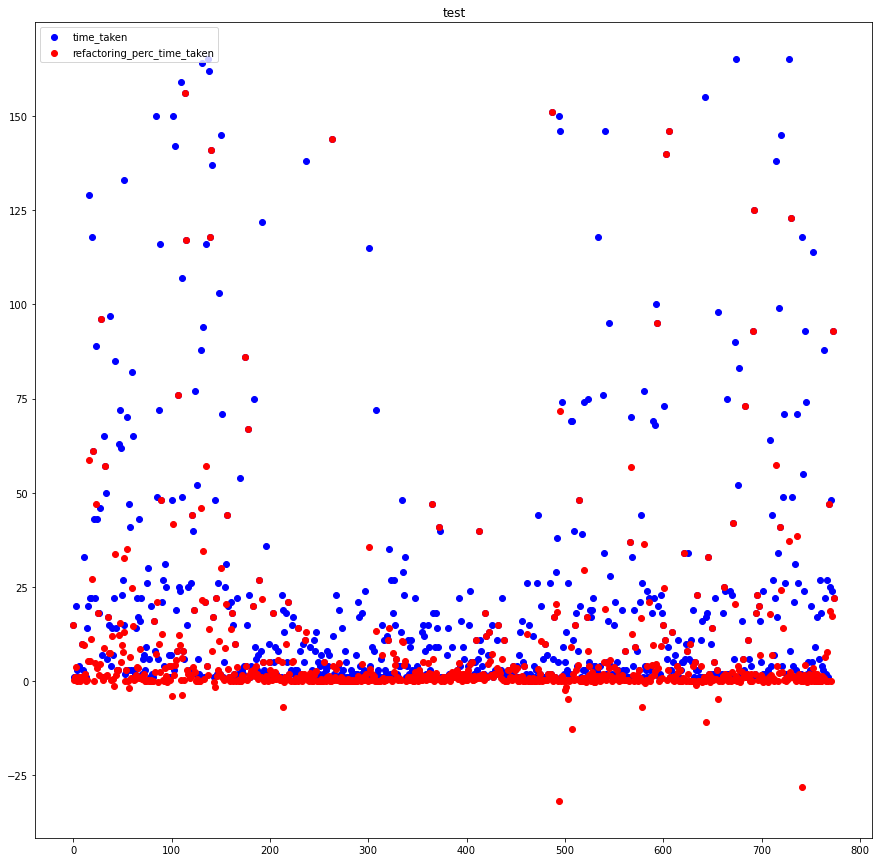

In [32]:
plotGraph(main_df['time_taken'], main_df['refactoring_perc_time_taken'],'time_taken','refactoring_perc_time_taken','test')

In [33]:
main_df = main_df[main_df['refactoring_perc_time_taken'] > 0]
#main_df = main_df[main_df['refactoring_perc_time_taken'] <= 8]
#main_df = main_df[main_df['refactoring_perc_time_taken'] <= 20]

#main_df = main_df[main_df['time_taken_final'] <= 60]
#main_df = main_df[main_df['time_taken_final'] > 2]

In [34]:
main_df['refactoring_perc_time_taken'].value_counts()

1.000000     27
2.000000     23
3.000000     11
4.000000      6
5.000000      6
             ..
0.008475      1
0.093458      1
32.716578     1
0.434164      1
0.213873      1
Name: refactoring_perc_time_taken, Length: 629, dtype: int64

In [35]:
def get_final_time_taken(row):
    if row['time_taken'] > row['time_taken_q90']:
        return row['time_taken'] - row['time_taken_q90']
    elif row['time_taken'] > row['time_taken_q80']:
        return row['time_taken'] - row['time_taken_q80']
    elif row['time_taken'] > row['time_taken_q60']:
        return row['time_taken'] - row['time_taken_q60']
    elif row['time_taken'] > row['time_taken_q40']:
        return row['time_taken'] - row['time_taken_q40']
    elif row['time_taken'] > row['time_taken_q20']:
        return row['time_taken'] - row['time_taken_q20']

In [36]:
main_df['time_taken_final'] = main_df.apply(lambda row: get_final_time_taken(row), axis=1)



In [37]:
#plotGraph(main_df['time_taken_final'], main_df['time_taken_mean'],' test')

{'whiskers': [<matplotlib.lines.Line2D at 0x1d3b58584a8>,
 'caps': [<matplotlib.lines.Line2D at 0x1d3b5858be0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d3b5858358>],
 'medians': [<matplotlib.lines.Line2D at 0x1d3b584b2b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d3b584b630>],
 'means': []}

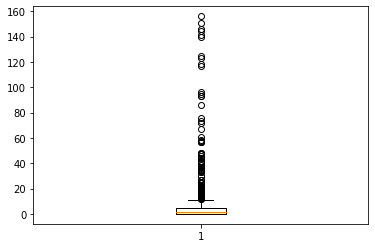

In [38]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1d3b54a9470>,
 'caps': [<matplotlib.lines.Line2D at 0x1d3b54a9ba8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d3b54a9320>],
 'medians': [<matplotlib.lines.Line2D at 0x1d3b549c2e8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d3b549c668>],
 'means': []}

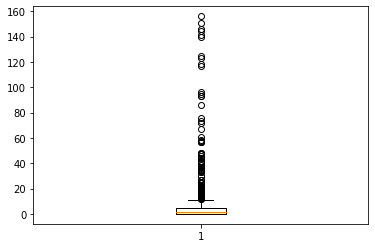

In [39]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

In [40]:
main_df['time_taken_final'].value_counts()

1.0     137
2.0      73
6.0      35
4.0      33
3.0      32
       ... 
0.6       1
2.4       1
1.2       1
10.6      1
32.7      1
Name: time_taken_final, Length: 119, dtype: int64

In [41]:
main_df = main_df.fillna(0)

In [42]:
main_df

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken,time_taken_final
0,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,0.000000,8,1.000000,15.000000,4.13952,2.477916,12.48,42.435515,7.0
1,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,0.000000,346,0.225434,0.225434,179.03424,107.076009,2229.76,519.589347,0.0
2,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,0.707107,35,1.000000,1.000000,18.11040,10.840124,189.60,113.234791,0.0
3,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,13,4.018895,194,0.185567,3.711340,100.38336,60.060503,1232.64,353.641141,1.0
4,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,136,50.585661,1938,0.004128,0.012384,1002.79872,597.273303,12673.28,1634.048307,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,3,0.866025,16,0.750000,18.750000,8.27904,4.955729,64.96,67.284406,5.0
2,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,10,2.946898,1696,0.004127,0.198113,877.57824,523.020584,11085.76,1495.349884,9.0
3,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,1,0.000000,535,0.725234,17.405607,276.83040,165.484354,3469.60,694.272395,4.0
4,7,27.645283,1.0,157.0,2.0,4.0,5.0,8.2,13.0,17.0,...,1,0.000000,4,1.000000,93.000000,2.06976,1.238971,-13.76,26.763600,19.4


Text(0.5, 1.0, 'Distribution of time for Refactoring Operations')

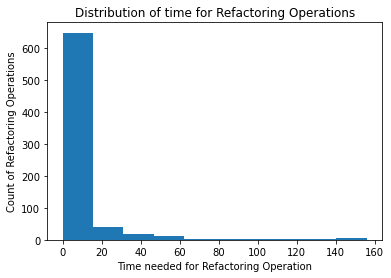

In [43]:
plt.hist(main_df['refactoring_perc_time_taken'])
plt.ylabel('Count of Refactoring Operations')
plt.xlabel('Time needed for Refactoring Operation')
plt.title('Distribution of time for Refactoring Operations')

Text(0.5, 1.0, 'Distribution of log(time) for Refactoring Operations')

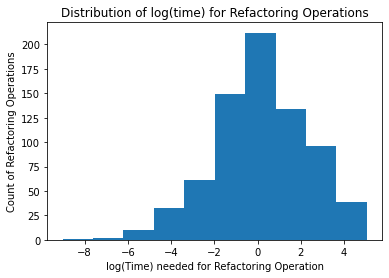

In [44]:
main_df['refactoring_perc_time_taken_log'] = np.log(main_df['refactoring_perc_time_taken'])
plt.hist(main_df['refactoring_perc_time_taken_log'])
plt.ylabel('Count of Refactoring Operations')
plt.xlabel('log(Time) needed for Refactoring Operation')
plt.title('Distribution of log(time) for Refactoring Operations')

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  2.,  5.,  2.,  8.,
         4.,  8., 13., 12., 15., 17., 17., 28., 45., 35., 41., 36., 64.,
        48., 64., 40., 39., 34., 21., 33., 28., 21., 14., 14., 10.,  5.,
        10.]),
 array([-9.02114525, -8.66937021, -8.31759518, -7.96582015, -7.61404512,
        -7.26227009, -6.91049506, -6.55872003, -6.206945  , -5.85516996,
        -5.50339493, -5.1516199 , -4.79984487, -4.44806984, -4.09629481,
        -3.74451978, -3.39274474, -3.04096971, -2.68919468, -2.33741965,
        -1.98564462, -1.63386959, -1.28209456, -0.93031953, -0.57854449,
        -0.22676946,  0.12500557,  0.4767806 ,  0.82855563,  1.18033066,
         1.53210569,  1.88388073,  2.23565576,  2.58743079,  2.93920582,
         3.29098085,  3.64275588,  3.99453091,  4.34630594,  4.69808098,
         5.04985601]),
 <a list of 40 Patch objects>)

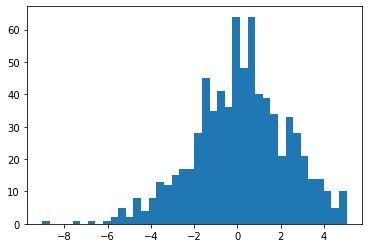

In [45]:
plt.hist(main_df['refactoring_perc_time_taken_log'],bins=40)

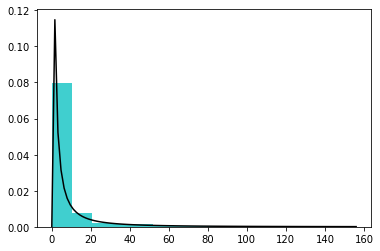

In [46]:
s, loc, scale = sp.stats.lognorm.fit(main_df['refactoring_perc_time_taken'], floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s


plt.hist(main_df['refactoring_perc_time_taken'], bins=15, density=True, color='c', alpha=0.75)
xmin = main_df['refactoring_perc_time_taken'].min()
xmin = 0
xmax = main_df['refactoring_perc_time_taken'].max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.lognorm.pdf(x, s, scale=scale)
plt.plot(x, pdf, 'k')

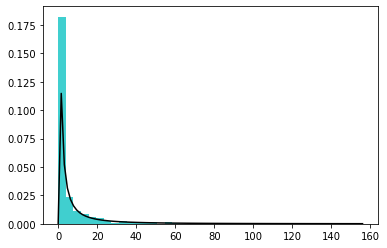

In [47]:
s, loc, scale = sp.stats.lognorm.fit(main_df['refactoring_perc_time_taken'], floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s


plt.hist(main_df['refactoring_perc_time_taken'], bins=40, density=True, color='c', alpha=0.75)
xmin = main_df['refactoring_perc_time_taken'].min()
xmin = 0
xmax = main_df['refactoring_perc_time_taken'].max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.lognorm.pdf(x, s, scale=scale)
plt.plot(x, pdf, 'k')

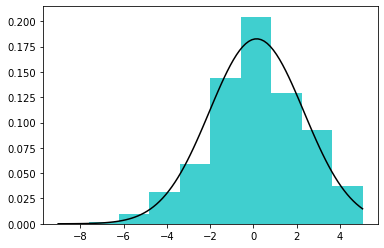

In [48]:
logdata = np.log(main_df['refactoring_perc_time_taken'])
plt.hist(logdata, bins=10, density=True, color='c', alpha=0.75)
xmin = logdata.min()
xmax = logdata.max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.norm.pdf(x, loc=estimated_mu, scale=estimated_sigma)
plt.plot(x, pdf, 'k')

In [49]:
len(main_df)

737

In [50]:
main_df.to_csv('test_effort_model.csv', index=False)

## EDA (Run only if absolutely necessary on minimum features)

In [51]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(main_df, title="Pandas Profiling Report",explorative=True)
#profile

In [52]:
for columns in main_df.columns:
    print(columns)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

### Only taking mean for num_dependency and num_line_affected since there is only one

In [53]:
final_col = []
column_to_skip = ['sha',
'name','email','login',
'date','message',
'parent_sha','parent_date',
'time_taken','contains_refactoring',
'kmean_label','time_taken_mean',
'time_taken_min',
'time_taken_max',
'time_taken_q10',
'time_taken_q20',
'time_taken_q25',
'time_taken_q30',
'time_taken_q40',
'time_taken_q50',
'time_taken_q60',
'time_taken_q70',
'time_taken_q75',
'time_taken_q80',
'time_taken_q90',
'project_name','commit_compared_with',
'actual_num_of_classes_touched_mean',
 'actual_num_of_classes_touched_min',
 'actual_num_of_classes_touched_max',
 'actual_num_of_classes_touched_std',
'num_dependency_min',
'num_dependency_max',
'num_dependency_std',
'num_line_affected_min',
'num_line_affected_max',
'num_line_affected_std', 'time_taken_final',
'commit_line_changed',
'refactoring_perc',
 'cocomoII_time_taken',
'geneticP_time_taken',
'softwareMaintenance_time_taken',
'fuzzy_time_taken',
'time_taken_final',
'refactoring_perc_time_taken'
 ]
for element in main_df.columns:
    #print("'" + element + "',")
    if element not in column_to_skip:
        final_col.append(element)

In [54]:
final_col

['cbo_mean',
 'cbo_min',
 'cbo_max',
 'cbo_std',
 'wmc_mean',
 'wmc_min',
 'wmc_max',
 'wmc_std',
 'dit_mean',
 'dit_min',
 'dit_max',
 'dit_std',
 'rfc_mean',
 'rfc_min',
 'rfc_max',
 'rfc_std',
 'lcom_mean',
 'lcom_min',
 'lcom_max',
 'lcom_std',
 'totalMethods_mean',
 'totalMethods_min',
 'totalMethods_max',
 'totalMethods_std',
 'staticMethods_mean',
 'staticMethods_min',
 'staticMethods_max',
 'staticMethods_std',
 'publicMethods_mean',
 'publicMethods_min',
 'publicMethods_max',
 'publicMethods_std',
 'privateMethods_mean',
 'privateMethods_min',
 'privateMethods_max',
 'privateMethods_std',
 'protectedMethods_mean',
 'protectedMethods_min',
 'protectedMethods_max',
 'protectedMethods_std',
 'defaultMethods_mean',
 'defaultMethods_min',
 'defaultMethods_max',
 'defaultMethods_std',
 'abstractMethods_mean',
 'abstractMethods_min',
 'abstractMethods_max',
 'abstractMethods_std',
 'finalMethods_mean',
 'finalMethods_min',
 'finalMethods_max',
 'finalMethods_std',
 'synchronizedMetho

In [55]:
X_col = final_col.copy()
X_col.remove('refactoring_perc_time_taken_log')
Y_col = ['refactoring_perc_time_taken_log']

X = main_df[X_col]
y = main_df[Y_col]
final_df = main_df[final_col]

In [56]:
X.head()

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
0,11.000000,11.0,11.0,0.000000,8.000000,8.0,8.0,0.000000,2.000000,2.0,...,58.000000,58.0,58.0,0.000000,17.000000,17.0,17.0,0.000000,85.000000,61.000000
1,12.000000,12.0,12.0,0.000000,8.000000,8.0,8.0,0.000000,1.000000,1.0,...,68.000000,68.0,68.0,0.000000,17.000000,17.0,17.0,0.000000,3.000000,78.000000
2,30.000000,30.0,30.0,0.000000,29.000000,29.0,29.0,0.000000,1.000000,1.0,...,103.000000,103.0,103.0,0.000000,1.000000,1.0,1.0,0.000000,78.000000,322.000000
3,23.250000,5.0,63.0,20.780782,20.666667,4.0,64.0,21.993112,2.000000,1.0,...,121.333333,37.0,320.0,98.919006,1.000000,1.0,1.0,0.000000,57.583333,222.666667
4,7.833333,0.0,31.0,11.027514,7.833333,1.0,21.0,7.444746,1.166667,1.0,...,63.500000,8.0,125.0,36.335557,10.333333,1.0,17.0,8.238858,54.333333,88.000000


In [57]:
y.head()

,refactoring_perc_time_taken_log
0,2.708050
1,-1.489730
2,0.000000
3,1.311393
4,-4.391358


## Feature Engineering

In [58]:
h2o.init(nthreads=4)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,11 mins 27 secs
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,5 months and 27 days !!!
H2O_cluster_name:,H2O_from_python_tanji_i1u227
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.924 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [59]:
from h2o.automl import H2OAutoML

full = h2o.H2OFrame(final_df)
train,test = full.split_frame(ratios=[.8], seed=16)


x = final_col
y = "refactoring_perc_time_taken_log"
x.remove(y)



Parse progress: |█████████████████████████████████████████████████████████| 100%


In [60]:
full.shape

(737, 163)

In [61]:
train[x].types

{'cbo_mean': 'real',
 'cbo_min': 'int',
 'cbo_max': 'int',
 'cbo_std': 'real',
 'wmc_mean': 'real',
 'wmc_min': 'int',
 'wmc_max': 'int',
 'wmc_std': 'real',
 'dit_mean': 'real',
 'dit_min': 'int',
 'dit_max': 'int',
 'dit_std': 'real',
 'rfc_mean': 'real',
 'rfc_min': 'int',
 'rfc_max': 'int',
 'rfc_std': 'real',
 'lcom_mean': 'real',
 'lcom_min': 'int',
 'lcom_max': 'int',
 'lcom_std': 'real',
 'totalMethods_mean': 'real',
 'totalMethods_min': 'int',
 'totalMethods_max': 'int',
 'totalMethods_std': 'real',
 'staticMethods_mean': 'real',
 'staticMethods_min': 'int',
 'staticMethods_max': 'int',
 'staticMethods_std': 'real',
 'publicMethods_mean': 'real',
 'publicMethods_min': 'int',
 'publicMethods_max': 'int',
 'publicMethods_std': 'real',
 'privateMethods_mean': 'real',
 'privateMethods_min': 'int',
 'privateMethods_max': 'int',
 'privateMethods_std': 'real',
 'protectedMethods_mean': 'real',
 'protectedMethods_min': 'int',
 'protectedMethods_max': 'int',
 'protectedMethods_std': 'r

In [62]:
train[y].types

{'refactoring_perc_time_taken_log': 'real'}

In [64]:
aml = H2OAutoML(max_models=25, seed=16, exclude_algos=['XGBoost'], exploitation_ratio=0.1)
#aml = H2OAutoML(max_models=10, seed=1, include_algos=['GLM'])
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |███████Failed polling AutoML progress log: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\tanji\\AppData\\Local\\Temp\\tmpryerc23i.csv'
██████████████████████████████████████████Failed polling AutoML progress log: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\tanji\\AppData\\Local\\Temp\\tmp6o65h_4d.csv'
███Failed polling AutoML progress log: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\tanji\\AppData\\Local\\Temp\\tmp6m247zre.csv'
████| 100%


In [65]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid__1_AutoML_20220228_154246_model_3,3.80376,1.95032,3.80376,1.55194,nan
GBM_5_AutoML_20220228_154246,3.80378,1.95033,3.80378,1.54977,nan
StackedEnsemble_BestOfFamily_AutoML_20220228_154246,3.80491,1.95062,3.80491,1.55764,nan
GBM_grid__1_AutoML_20220228_154246_model_6,3.8335,1.95793,3.8335,1.55858,nan
GBM_2_AutoML_20220228_154246,3.89808,1.97435,3.89808,1.56925,nan
GBM_grid__1_AutoML_20220228_154246_model_2,3.93183,1.98288,3.93183,1.57568,nan
GBM_grid__1_AutoML_20220228_154246_model_4,3.93756,1.98433,3.93756,1.58655,nan
GBM_grid__1_AutoML_20220228_154246_model_1,3.94667,1.98662,3.94667,1.58638,nan
XRT_1_AutoML_20220228_154246,3.95319,1.98826,3.95319,1.57474,nan
GBM_3_AutoML_20220228_154246,3.96841,1.99209,3.96841,1.59031,nan


gbm prediction progress: |████████████████████████████████████████████████| 100%


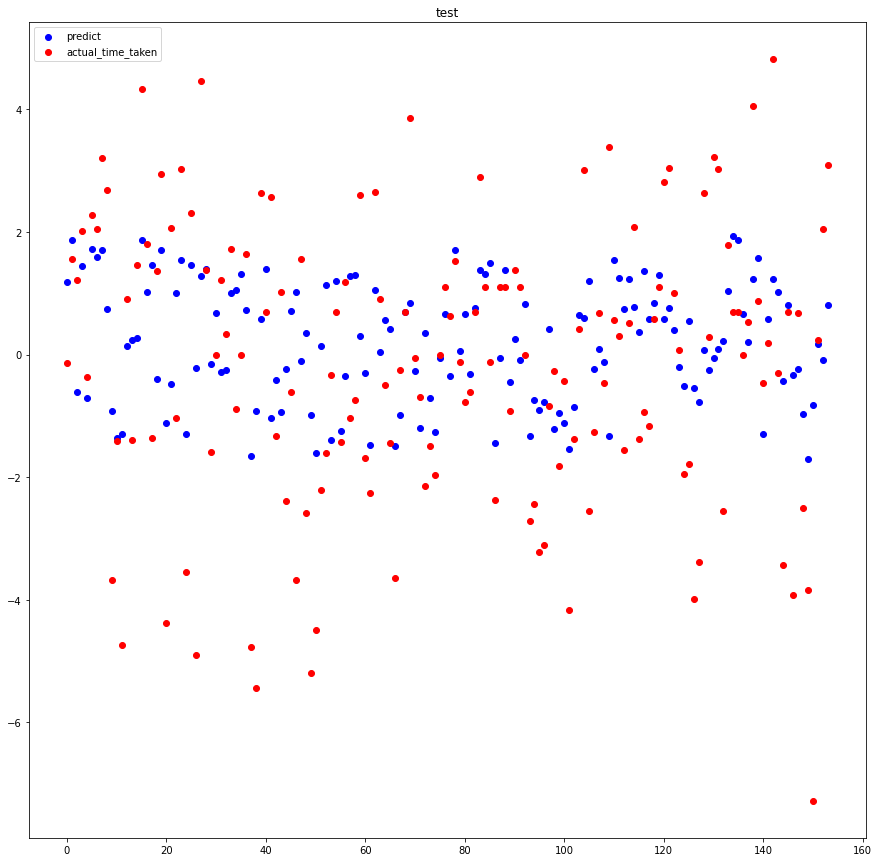

gbm prediction progress: |████████████████████████████████████████████████| 100%


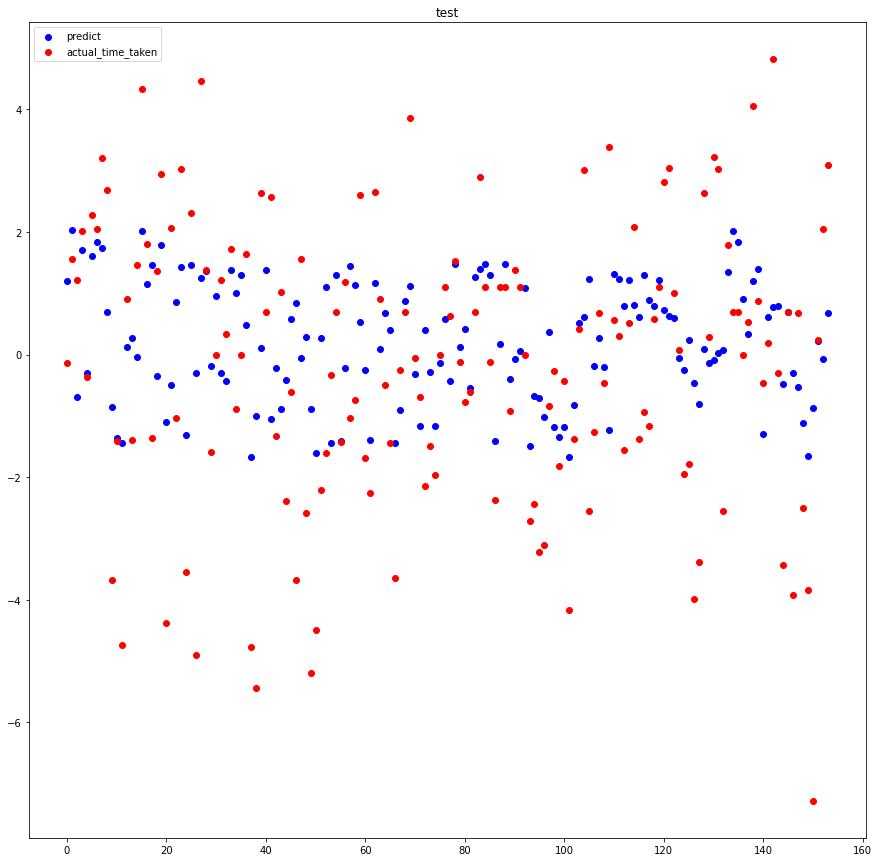

stackedensemble prediction progress: |████████████████████████████████████| 100%


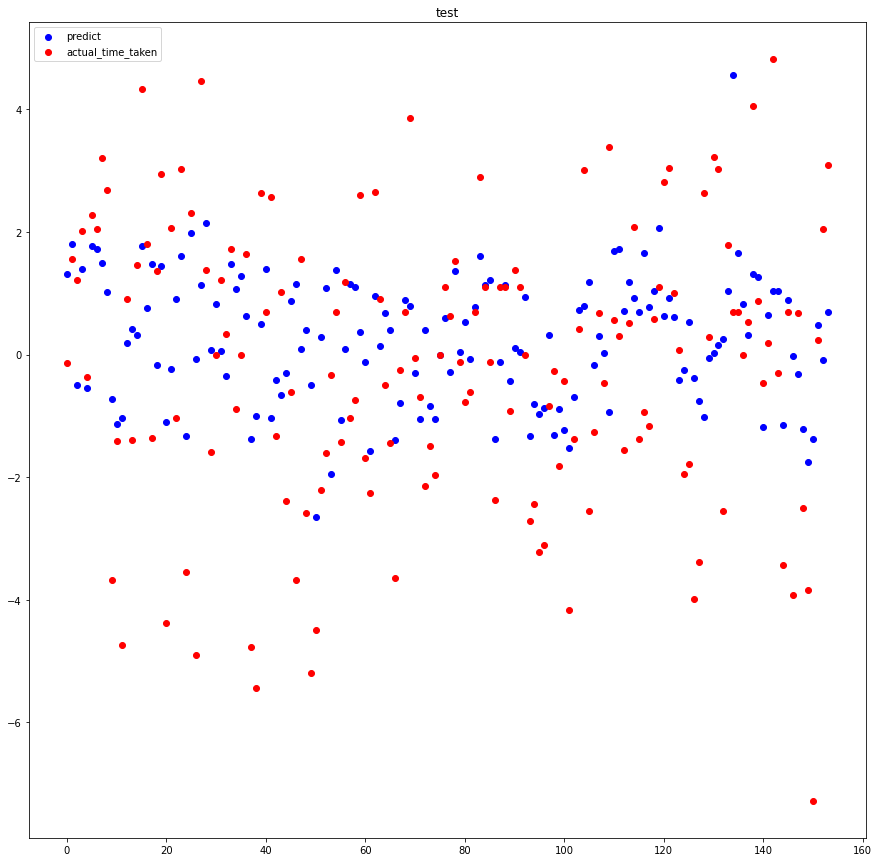

gbm prediction progress: |████████████████████████████████████████████████| 100%


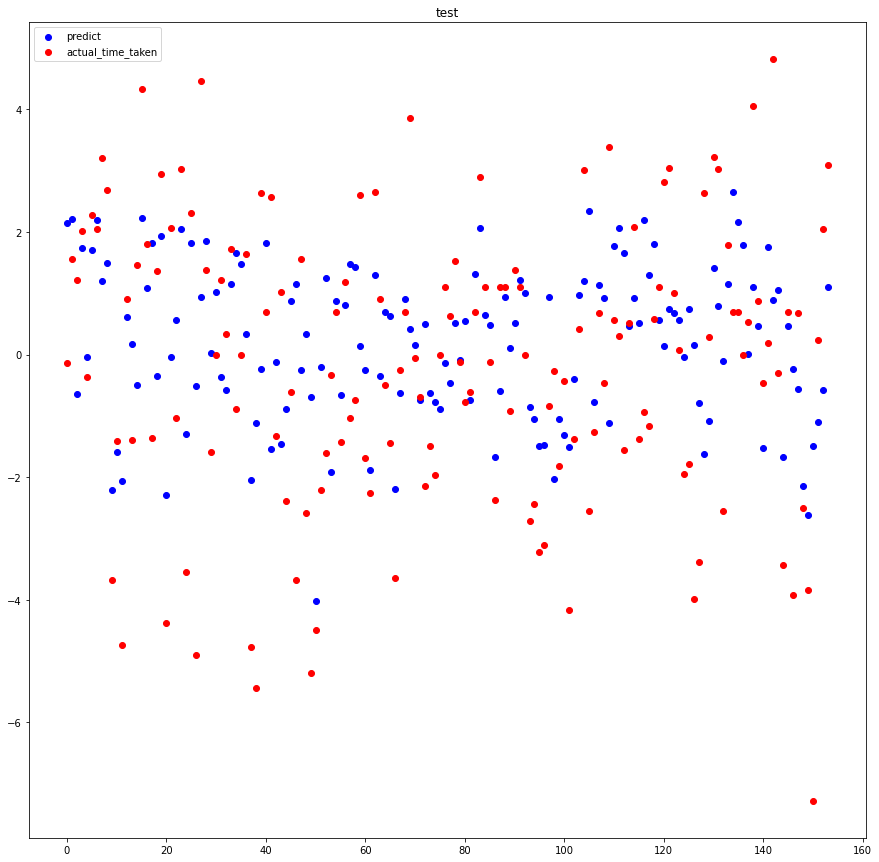

gbm prediction progress: |████████████████████████████████████████████████| 100%


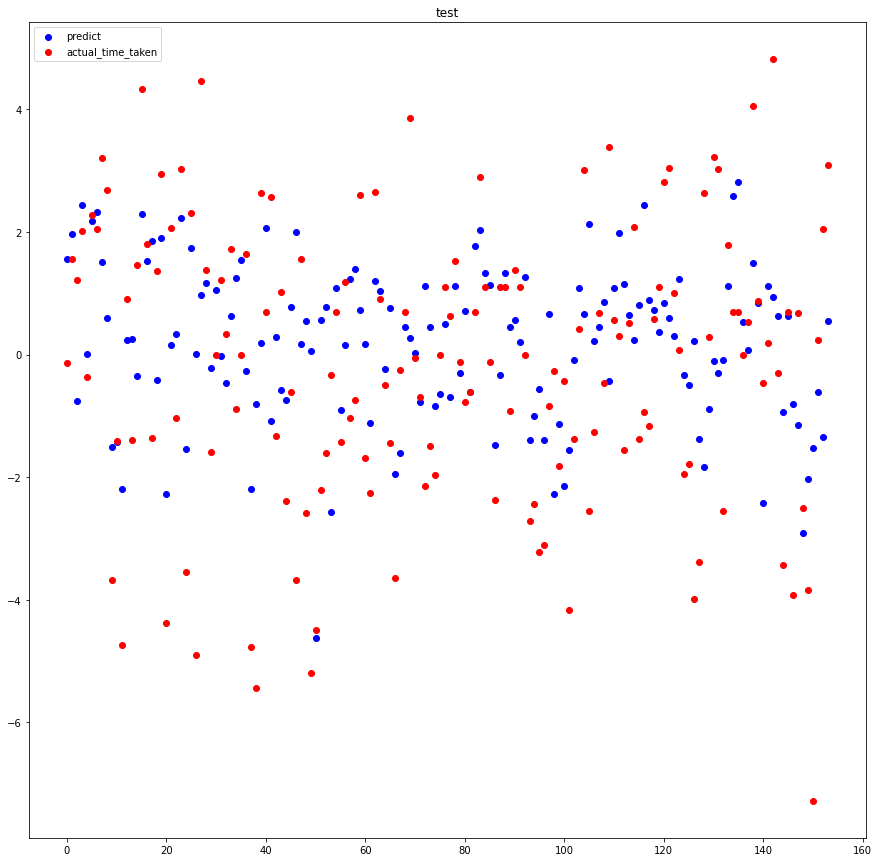

gbm prediction progress: |████████████████████████████████████████████████| 100%


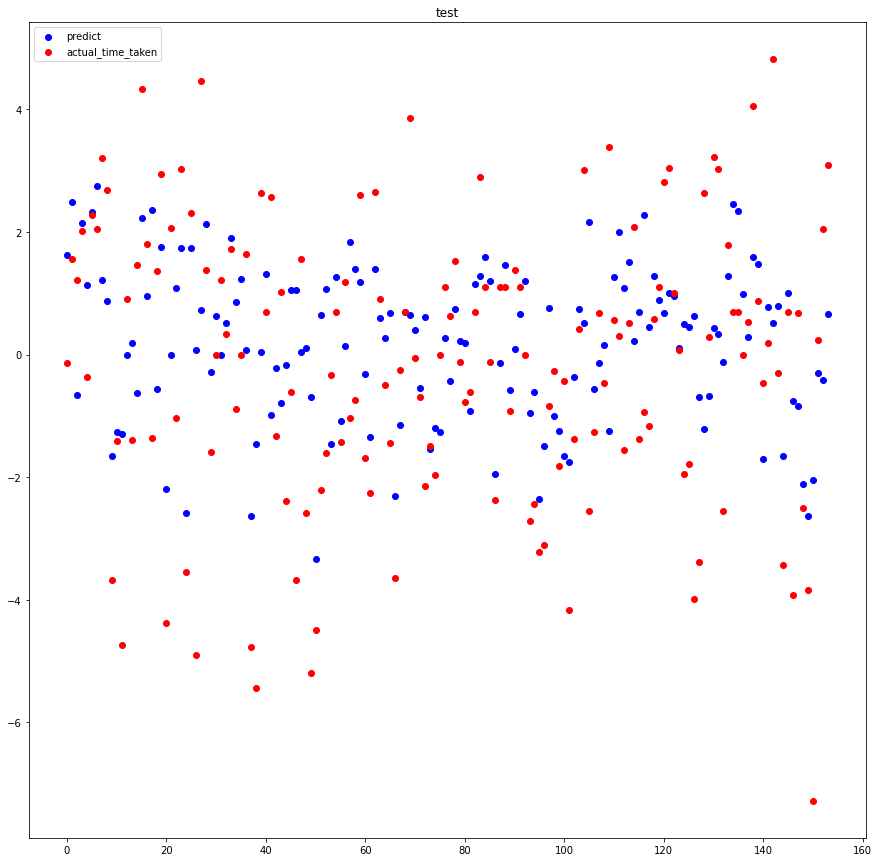

gbm prediction progress: |████████████████████████████████████████████████| 100%


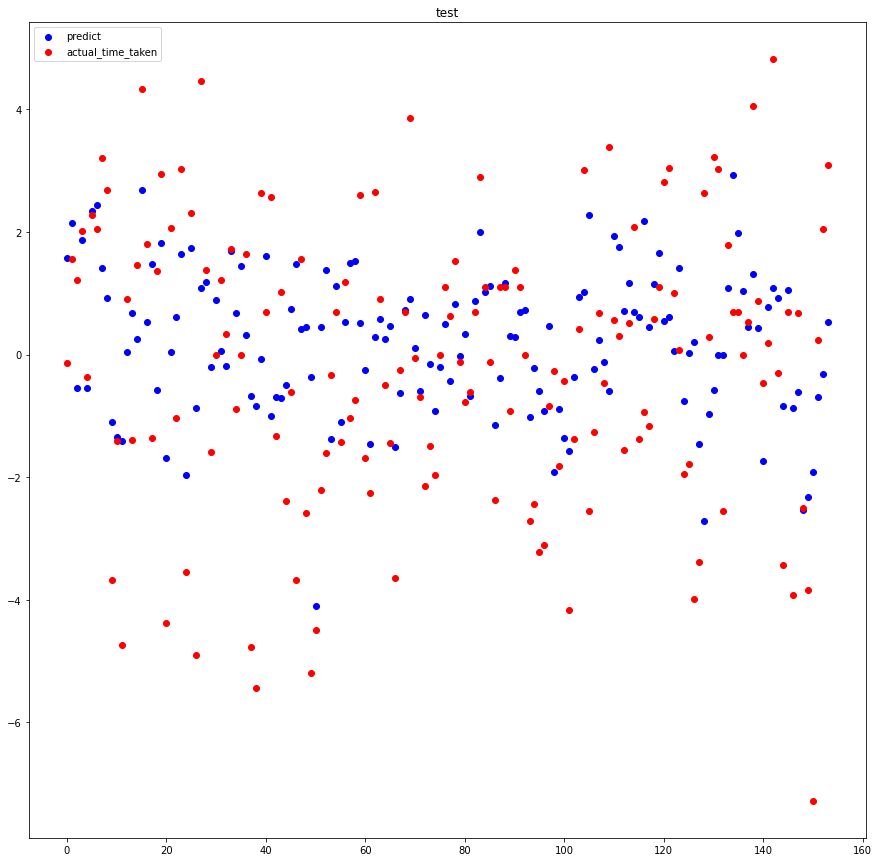

gbm prediction progress: |████████████████████████████████████████████████| 100%


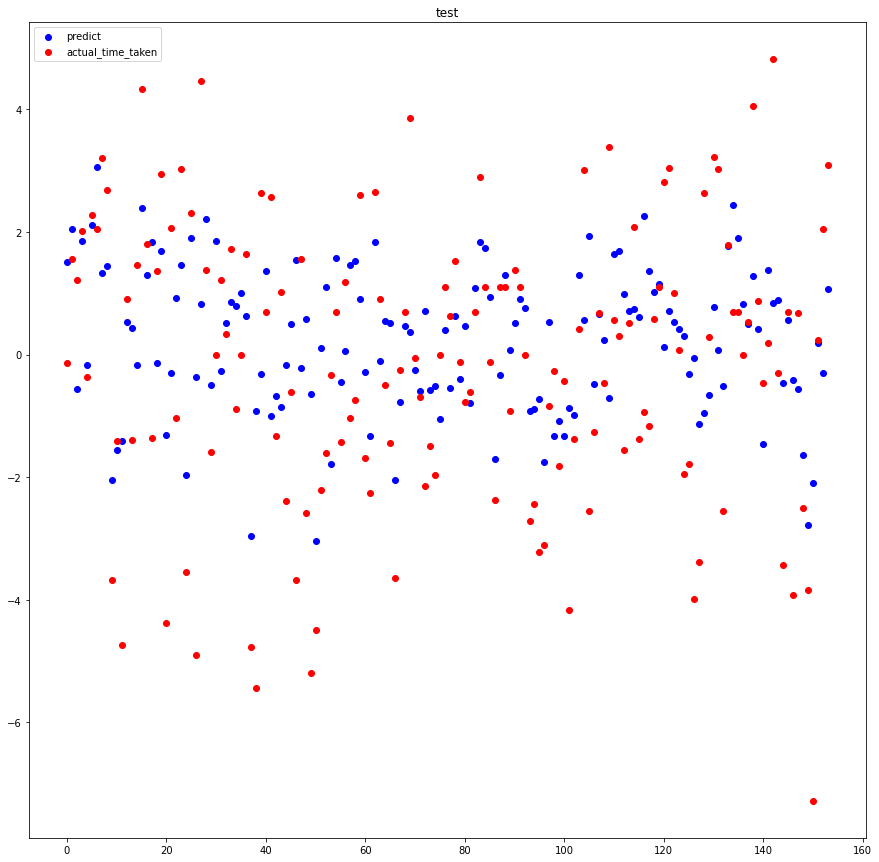

drf prediction progress: |████████████████████████████████████████████████| 100%


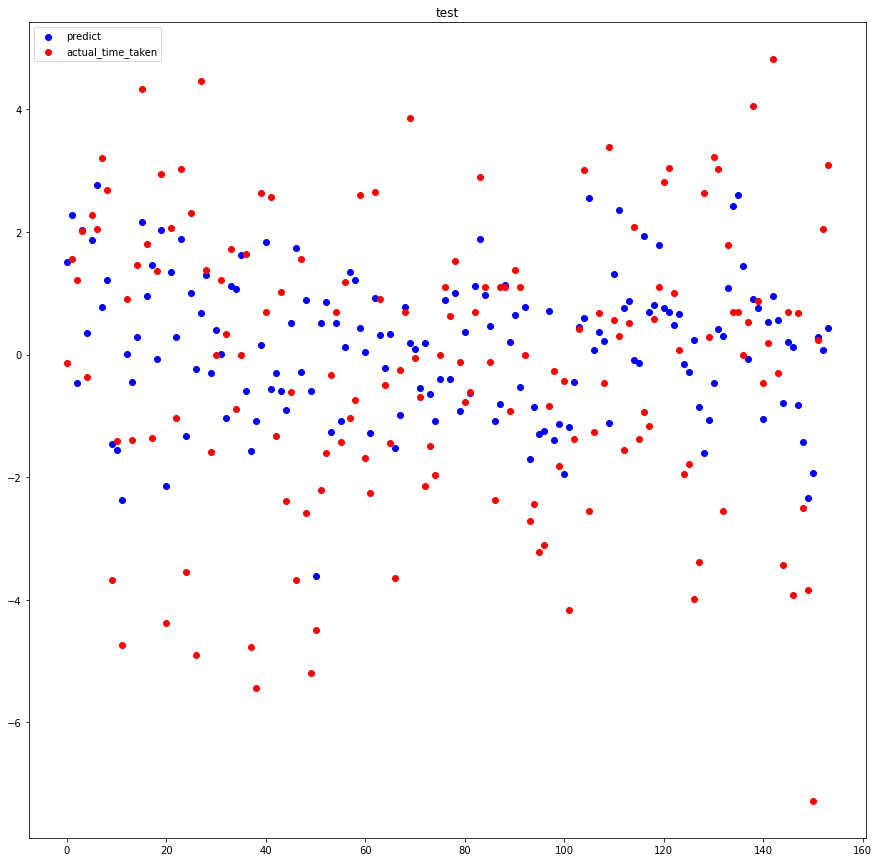

gbm prediction progress: |████████████████████████████████████████████████| 100%


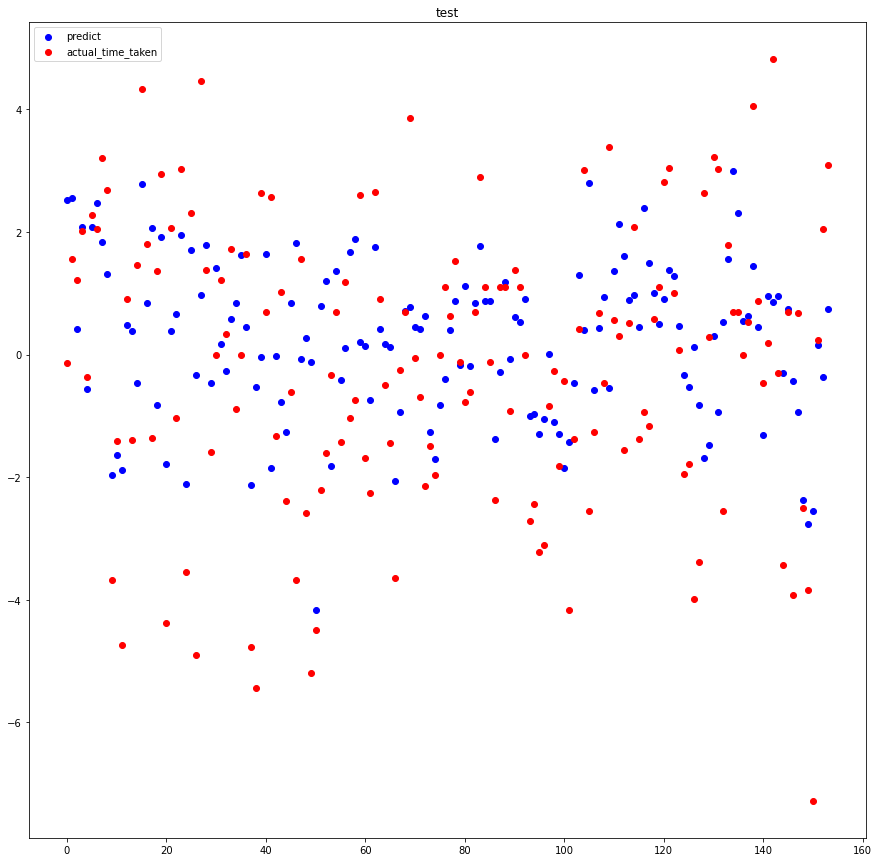

gbm prediction progress: |████████████████████████████████████████████████| 100%


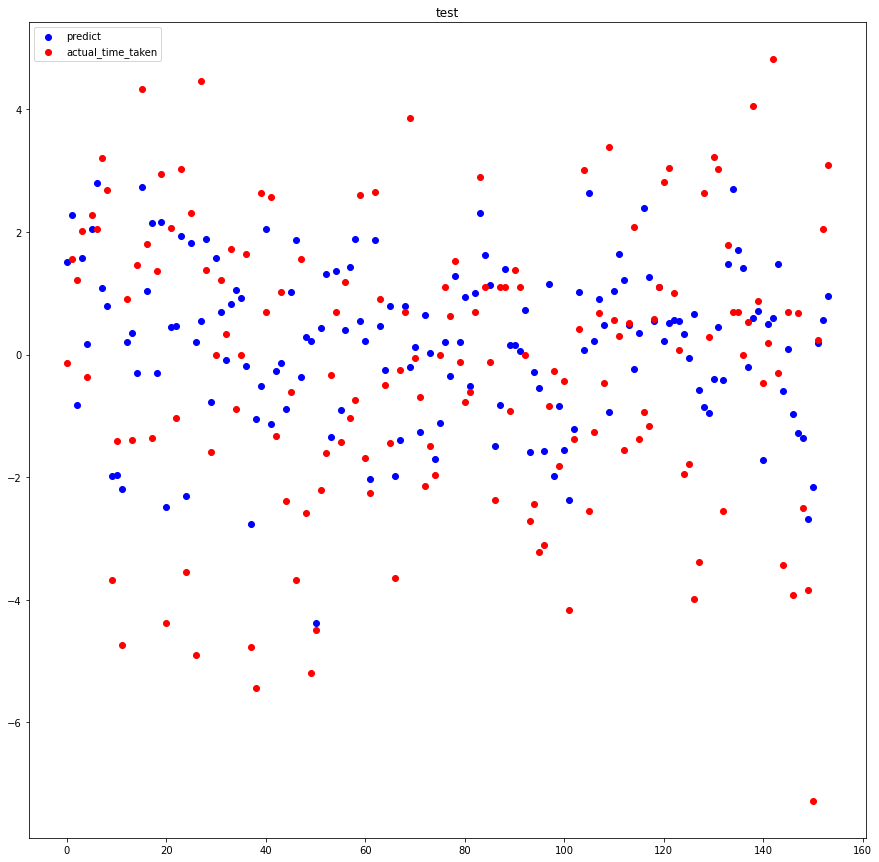

deeplearning prediction progress: |███████████████████████████████████████| 100%


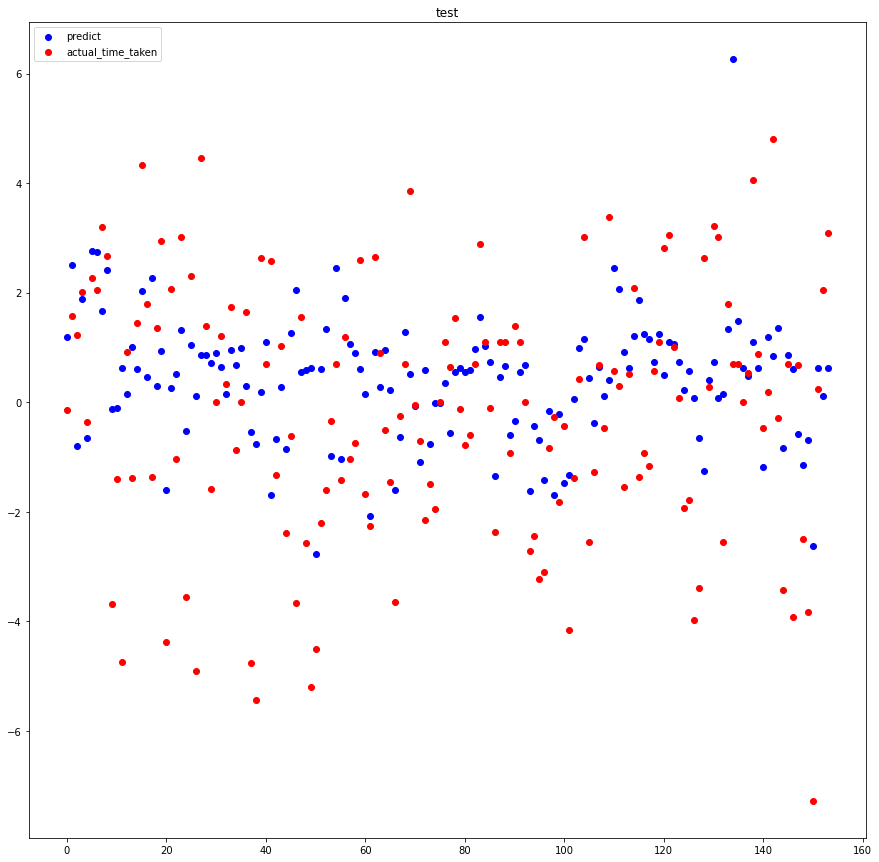

drf prediction progress: |████████████████████████████████████████████████| 100%


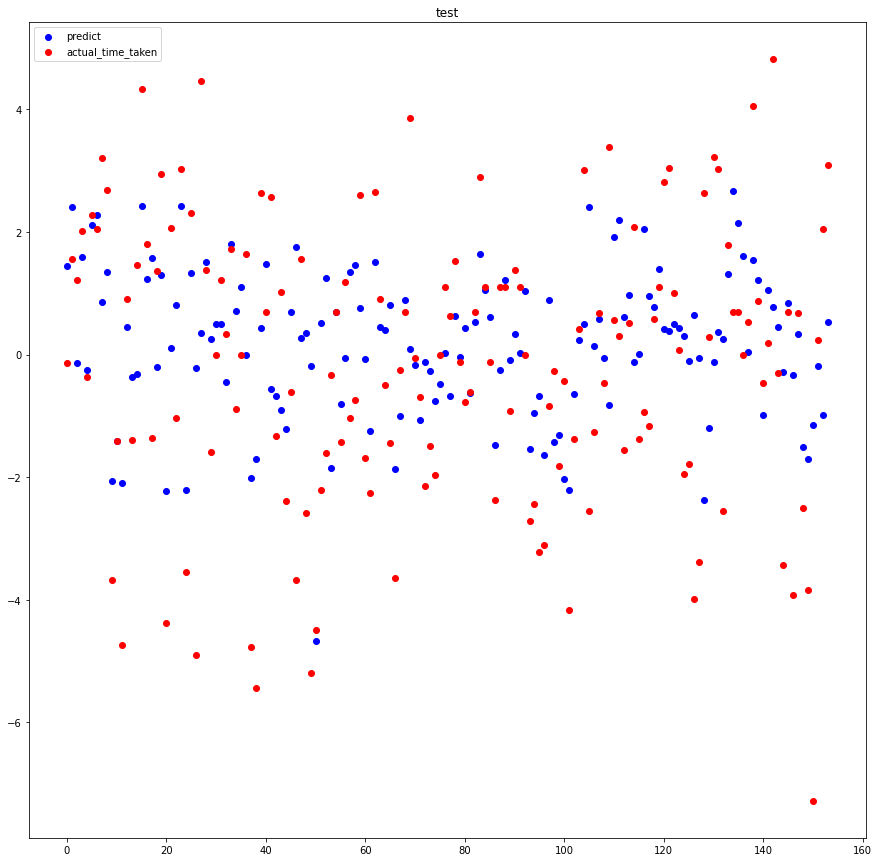

deeplearning prediction progress: |███████████████████████████████████████| 100%


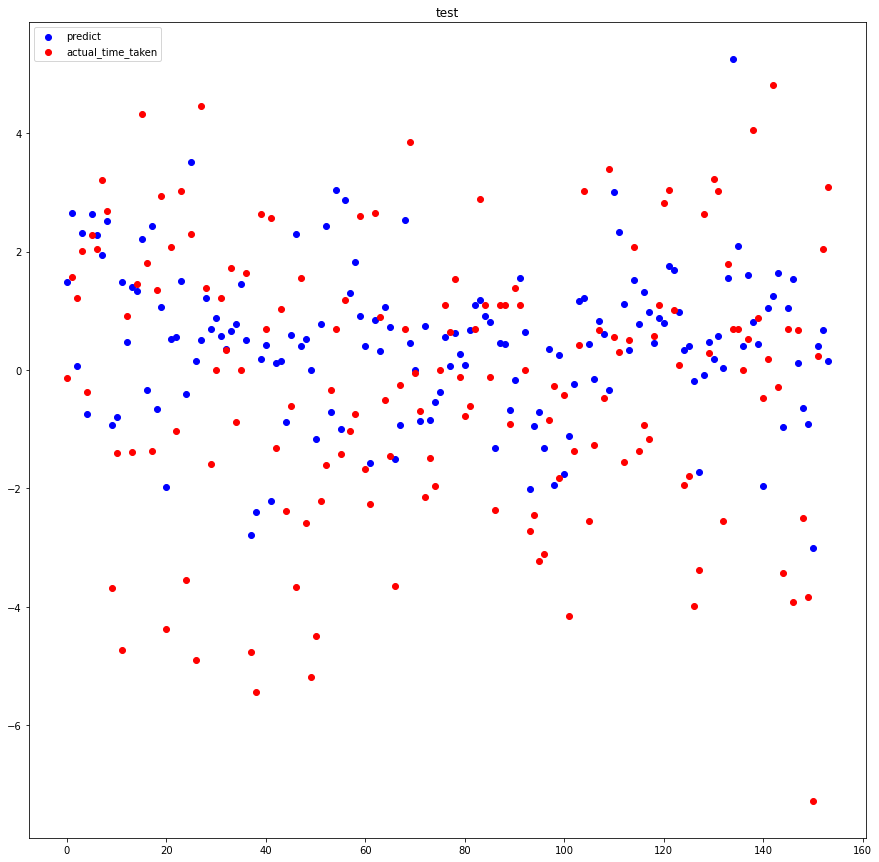

glm prediction progress: |████████████████████████████████████████████████| 100%


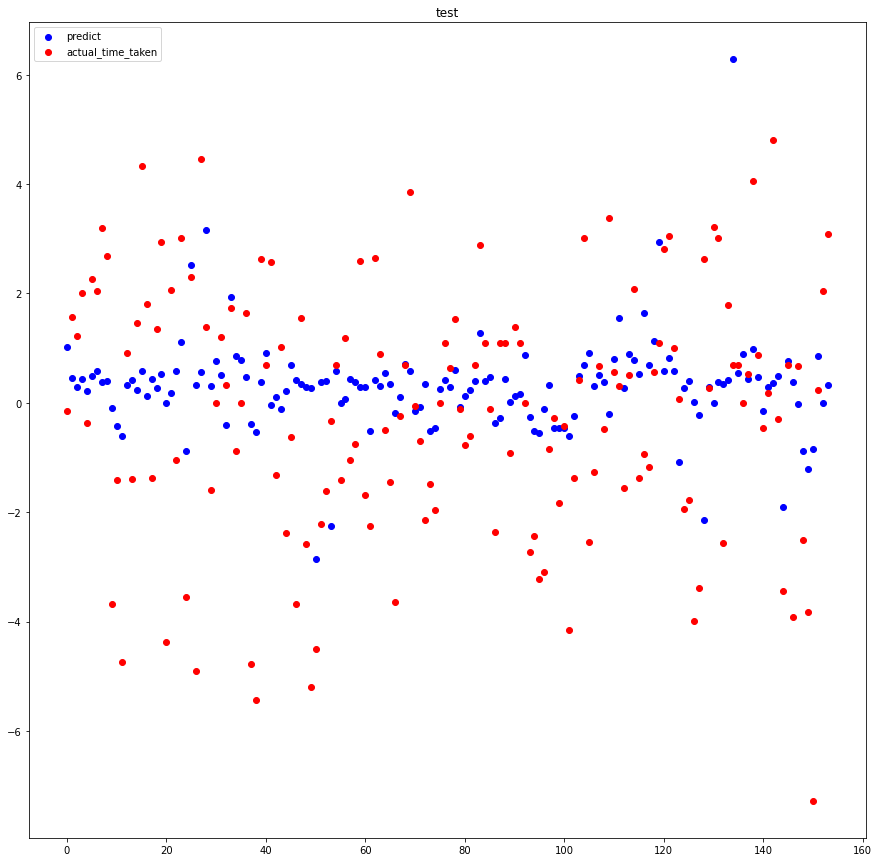

gbm prediction progress: |████████████████████████████████████████████████| 100%


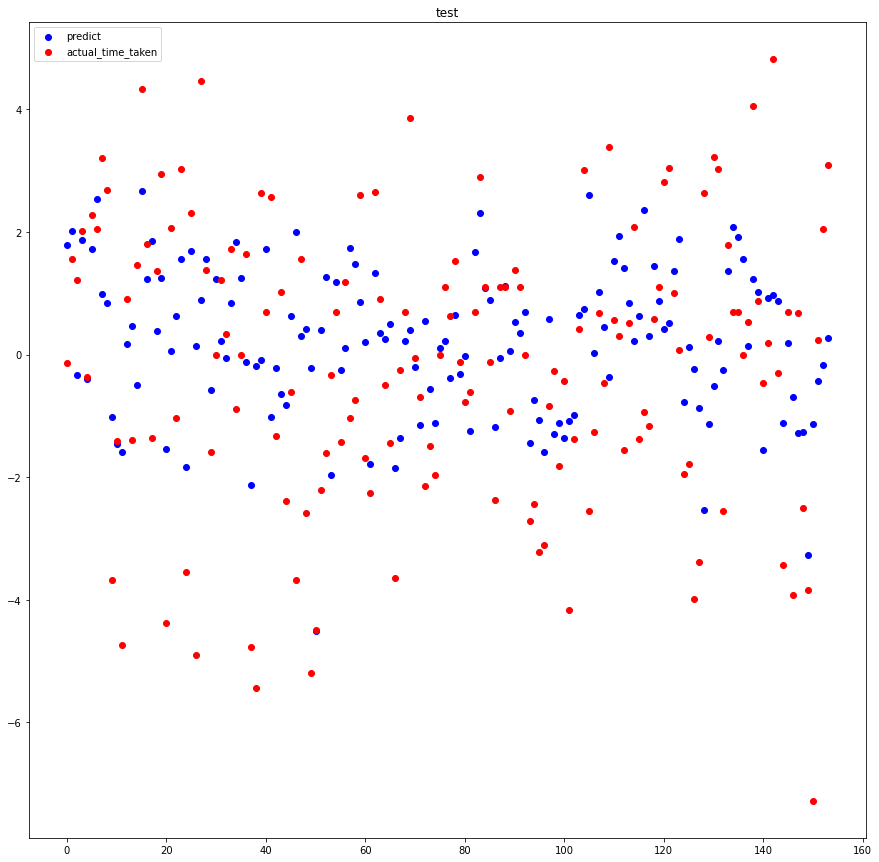

gbm prediction progress: |████████████████████████████████████████████████| 100%


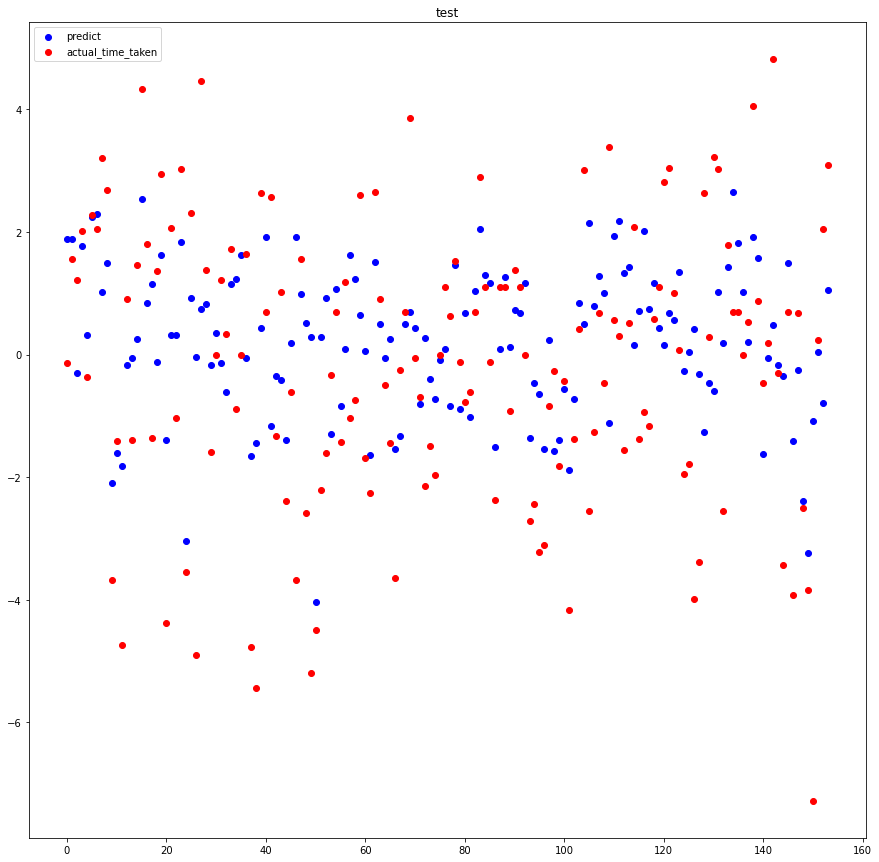

stackedensemble prediction progress: |████████████████████████████████████| 100%


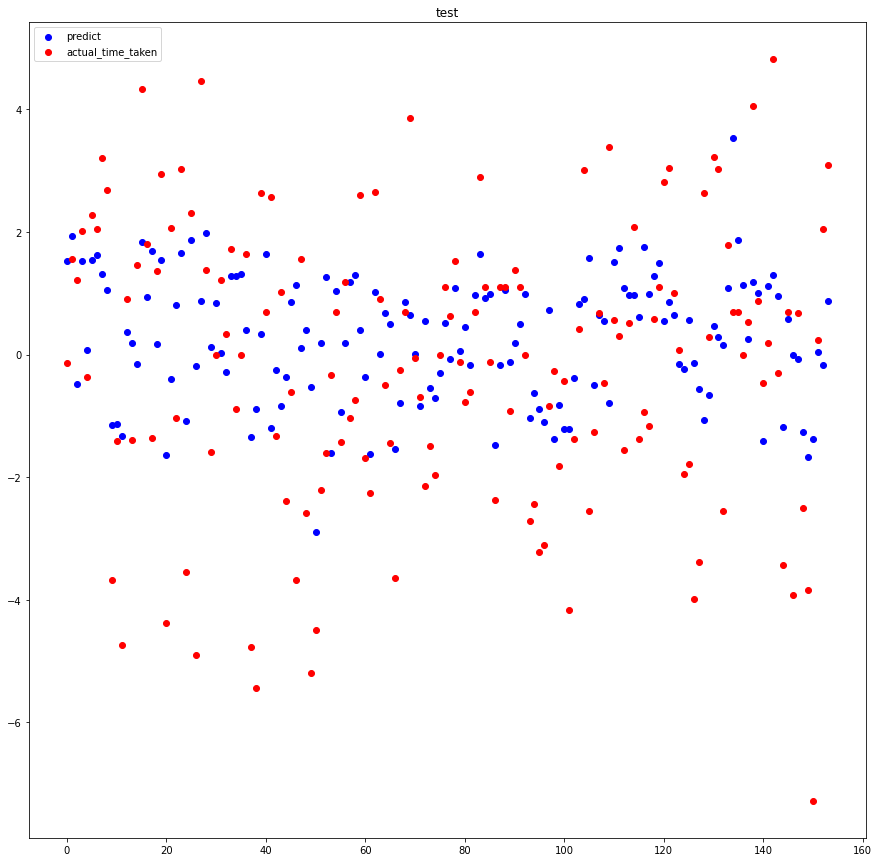

gbm prediction progress: |████████████████████████████████████████████████| 100%


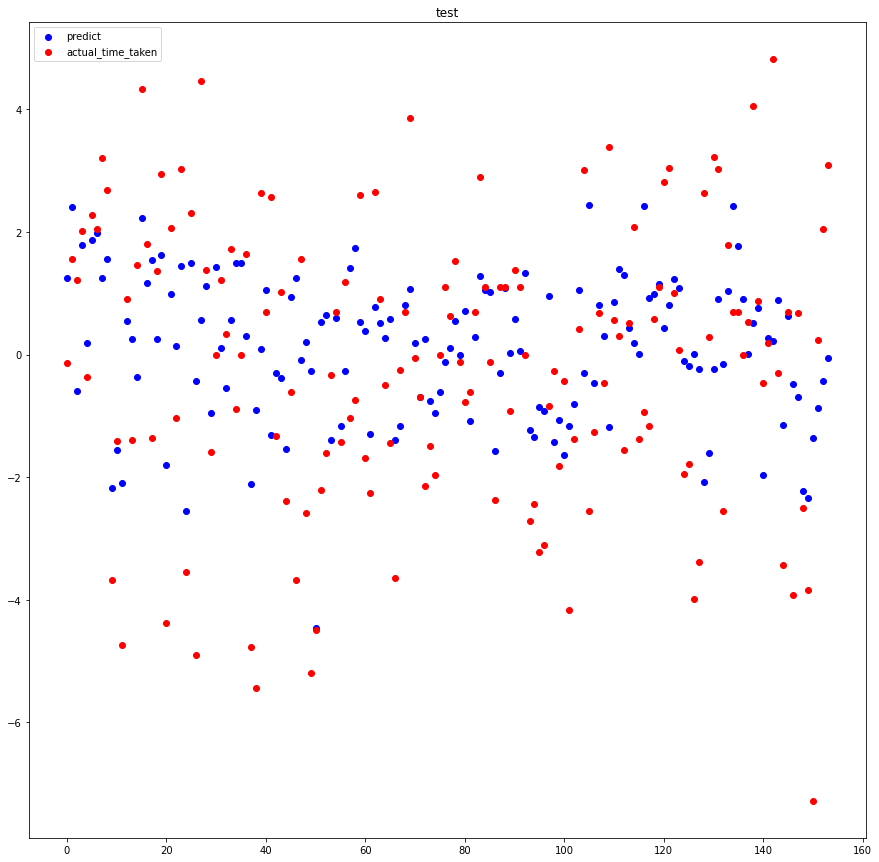

deeplearning prediction progress: |███████████████████████████████████████| 100%


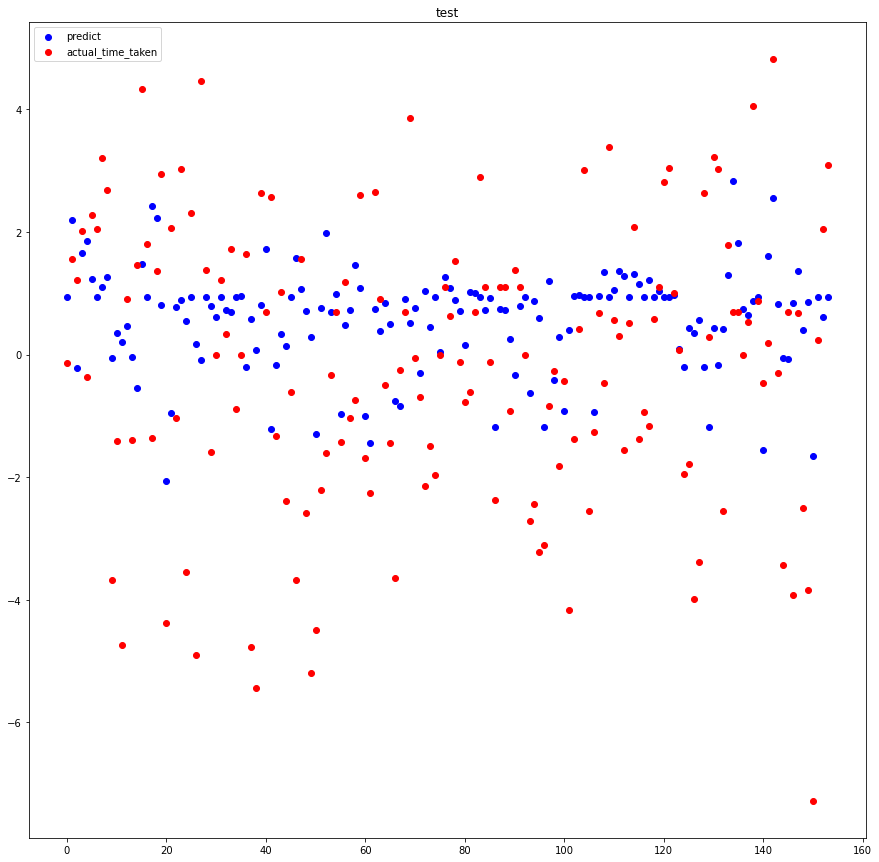

deeplearning prediction progress: |███████████████████████████████████████| 100%


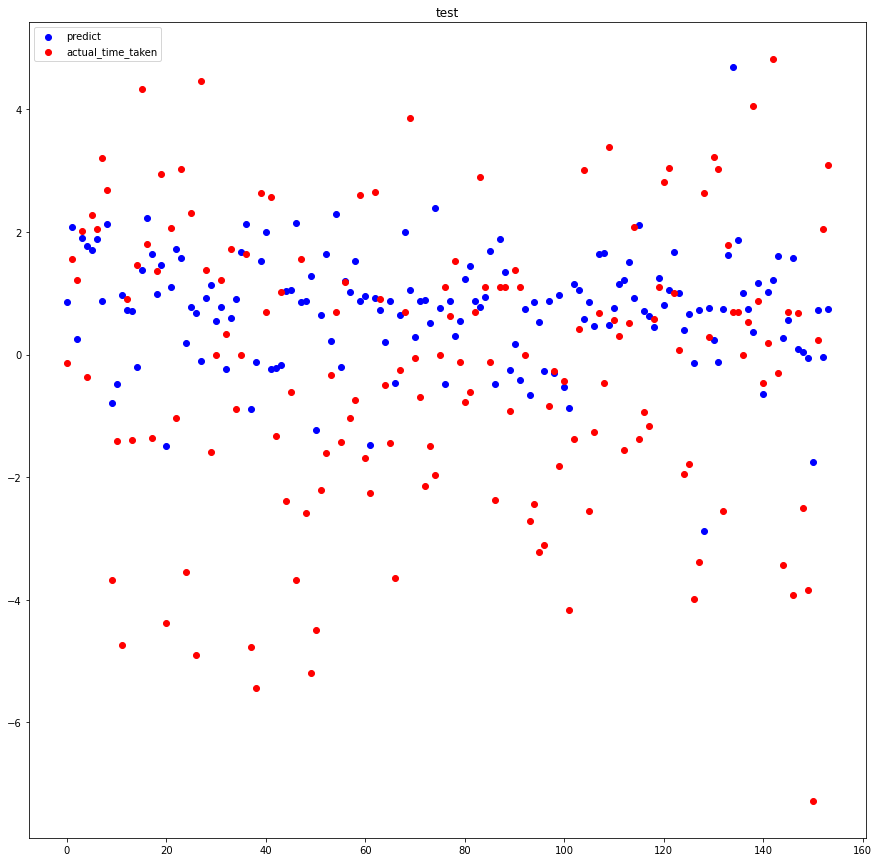

deeplearning prediction progress: |███████████████████████████████████████| 100%


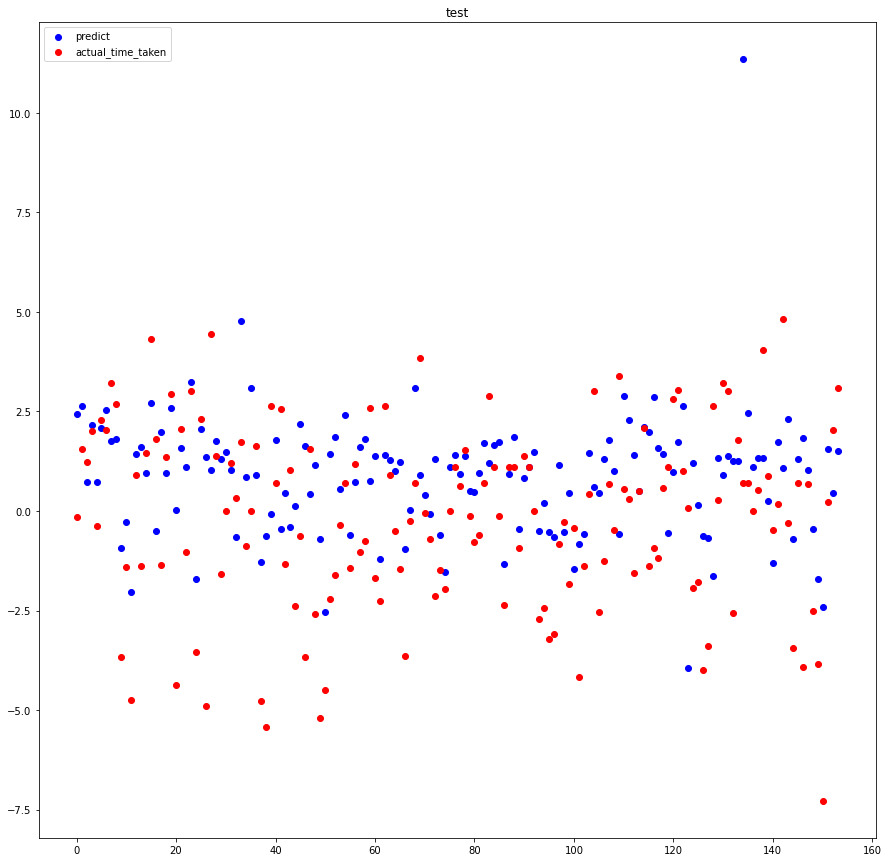

deeplearning prediction progress: |███████████████████████████████████████| 100%


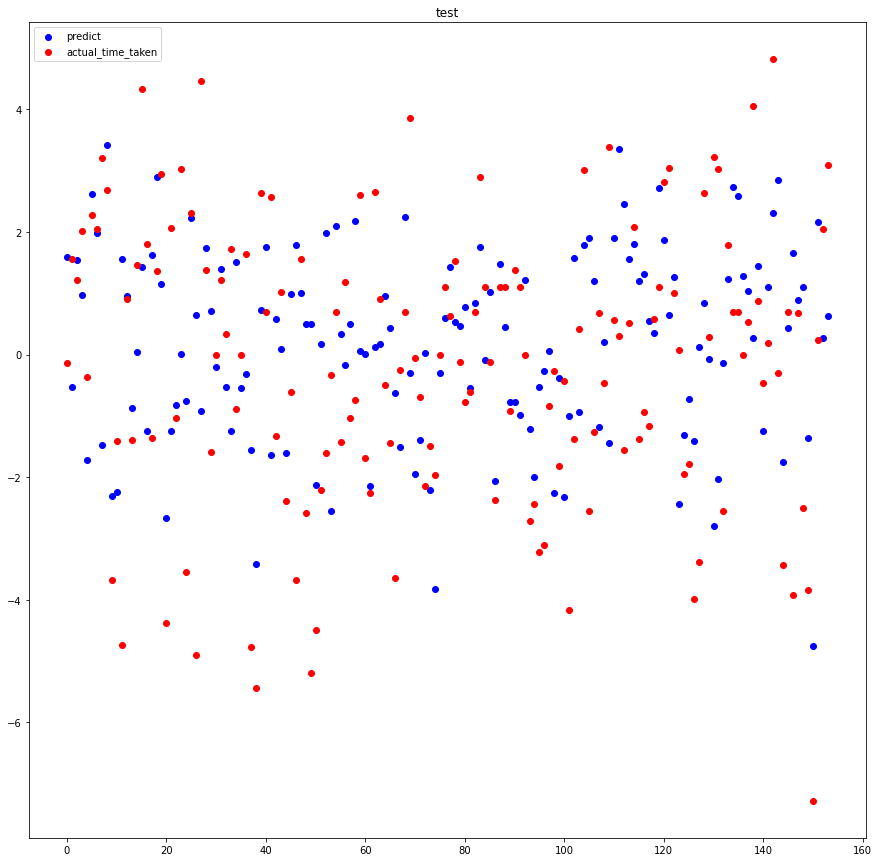

deeplearning prediction progress: |███████████████████████████████████████| 100%


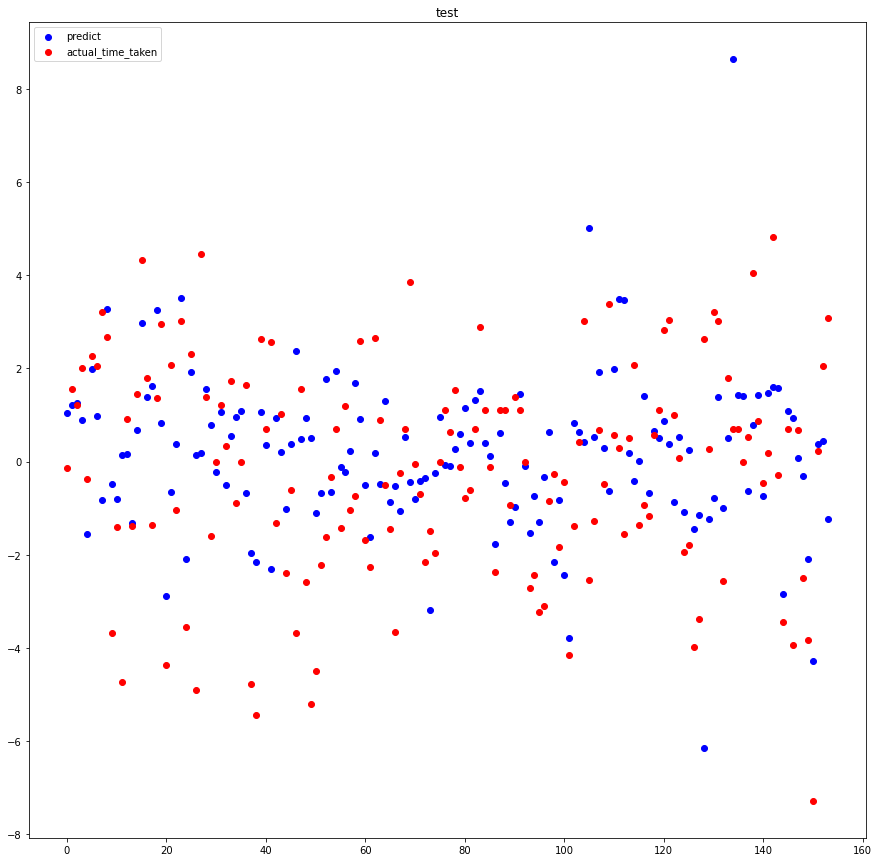

deeplearning prediction progress: |███████████████████████████████████████| 100%


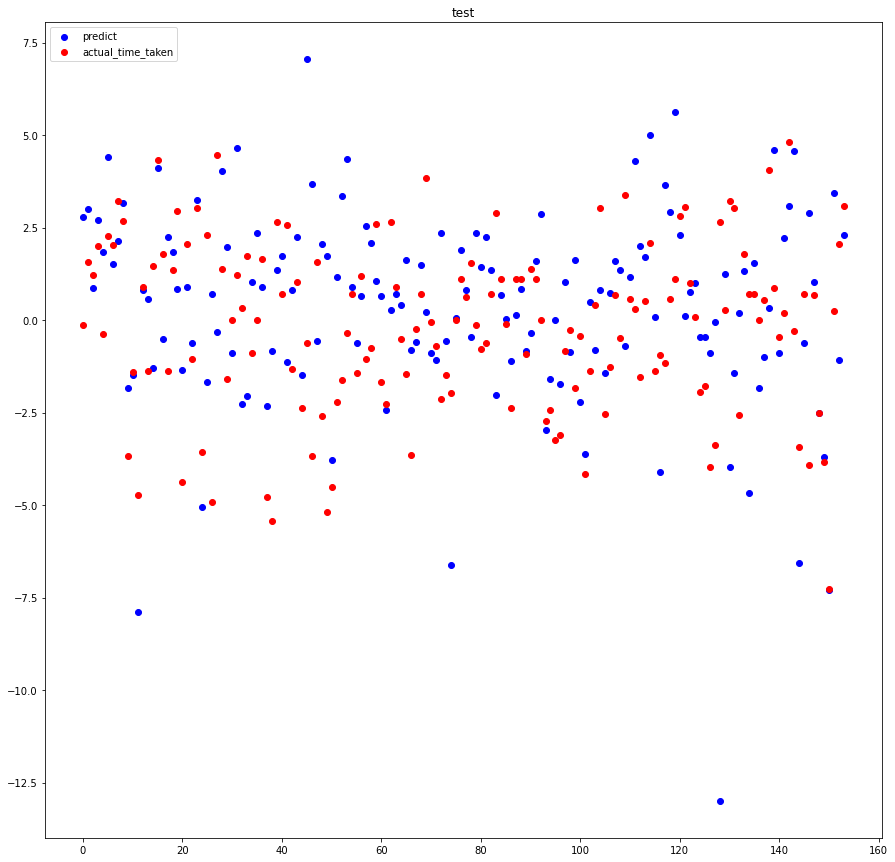

In [68]:
for i in range(25):
    model = h2o.get_model(lb[i,'model_id'])
    preds = model.predict(test)
    pd_preds = preds.as_data_frame()
    pd_test = test.as_data_frame()
    pd_preds['actual_time_taken'] = pd_test['refactoring_perc_time_taken_log']
    #pd_preds.loc[(pd_preds.predict < 0),'predict']=1
    plotGraphandSave(pd_preds['predict'], pd_preds['actual_time_taken'],'predict','actual_time_taken','test', i)
    

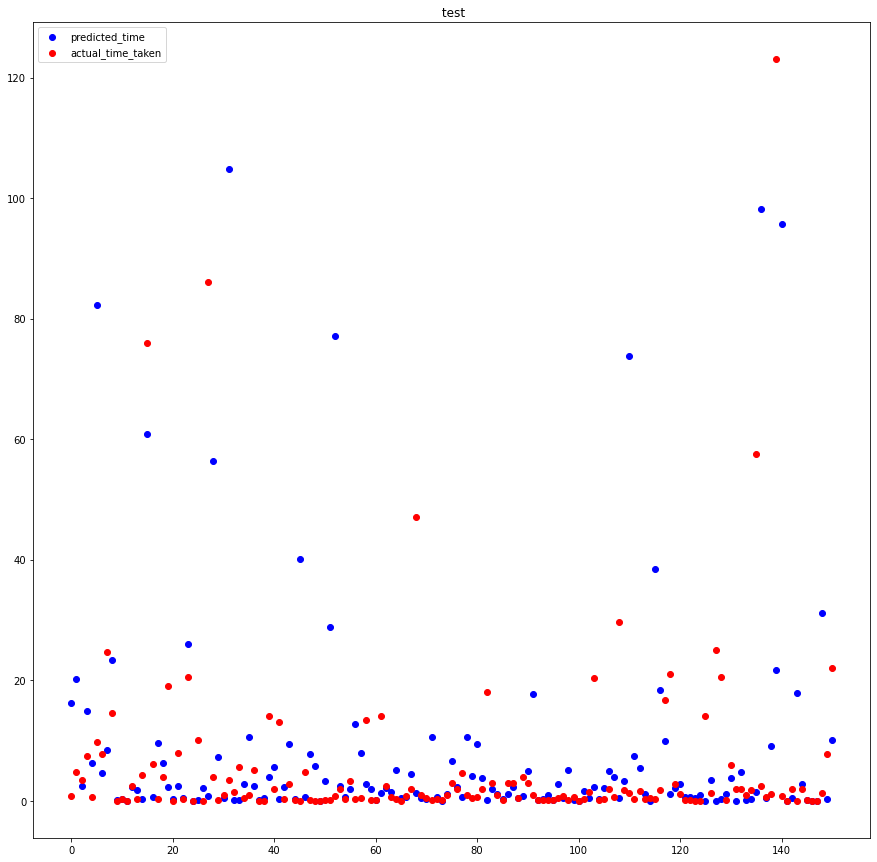

In [77]:
visualization = pd_preds[pd_preds['predict'] <= 5]
#visualization = pd_preds[pd_preds['actual_time_taken'] <= 20]
plotGraph(np.exp(visualization['predict']), np.exp(visualization['actual_time_taken']),'predicted_time','actual_time_taken',' test')

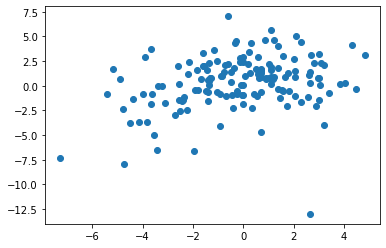

In [74]:
import matplotlib.pyplot as plt
plt.scatter(pd_preds['actual_time_taken'], pd_preds['predict'])

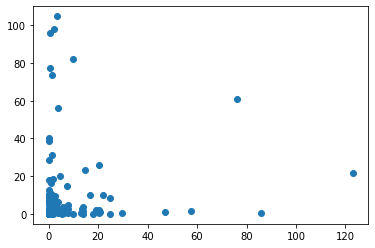

In [76]:
import matplotlib.pyplot as plt
plt.scatter(np.exp(visualization['actual_time_taken']), np.exp(visualization['predict']))

In [78]:
model = h2o.get_model(lb[0,'model_id'])

In [64]:
model

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid__1_AutoML_20220228_154246_model_3


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,33.0,33.0,3454.0,2.0,3.0,2.575757,3.0,4.0,3.666667




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 3.2044038310962666
RMSE: 1.7900848670094573
MAE: 1.424412915308594
RMSLE: NaN
Mean Residual Deviance: 3.2044038310962666

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 3.8037588457541194
RMSE: 1.9503227542522594
MAE: 1.5519355816853435
RMSLE: NaN
Mean Residual Deviance: 3.8037588457541194

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,1.5520502,0.08237011,1.4910178,1.467426,1.6308649,1.5229915,1.647951
1,mean_residual_deviance,3.80427,0.3442388,3.4929738,3.5808723,4.040876,3.6165812,4.2900476
2,mse,3.80427,0.3442388,3.4929738,3.5808723,4.040876,3.6165812,4.2900476
3,r2,0.17276023,0.03720194,0.19935311,0.19155143,0.121441506,0.20593041,0.14552468
4,residual_deviance,3.80427,0.3442388,3.4929738,3.5808723,4.040876,3.6165812,4.2900476
5,rmse,1.9488872,0.08738271,1.8689499,1.8923193,2.0101929,1.9017311,2.071243
6,rmsle,NaN,0.0,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-02-28 15:43:08,1.653 sec,0.0,2.146777,1.667285,4.608652
1,,2022-02-28 15:43:08,1.673 sec,5.0,2.014709,1.580553,4.059051
2,,2022-02-28 15:43:08,1.693 sec,10.0,1.932624,1.522236,3.735036
3,,2022-02-28 15:43:08,1.717 sec,15.0,1.881267,1.490755,3.539164
4,,2022-02-28 15:43:08,1.742 sec,20.0,1.851262,1.472042,3.427170
5,,2022-02-28 15:43:08,1.771 sec,25.0,1.823754,1.451458,3.326080
6,,2022-02-28 15:43:08,1.792 sec,30.0,1.801777,1.435145,3.246400
7,,2022-02-28 15:43:08,1.805 sec,33.0,1.790085,1.424413,3.204404



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,uniqueWordsQty_min,1156.941528,1.000000,0.268673
1,loc_min,555.740234,0.480353,0.129058
2,cbo_std,502.424957,0.434270,0.116676
3,privateFields_std,247.563660,0.213981,0.057491
4,finalFields_std,219.819809,0.190001,0.051048
5,nosi_min,205.712997,0.177808,0.047772
6,staticFields_mean,192.080521,0.166024,0.044606
7,nosi_mean,106.552544,0.092098,0.024744
8,subClassesQty_mean,103.979286,0.089874,0.024147
9,finalFields_mean,102.416138,0.088523,0.023784



See the whole table with table.as_data_frame()


In [65]:
preds = model.predict(test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [88]:
preds.shape

(154, 1)

In [67]:
pd_preds = preds.as_data_frame()
pd_preds['predict'].value_counts()

 1.870472    2
 0.423327    2
 1.395649    1
 1.027848    1
 1.288632    1
            ..
 0.141635    1
-1.029819    1
 0.833039    1
 0.174653    1
 0.053230    1
Name: predict, Length: 152, dtype: int64

In [68]:
train.head()

cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,dit_max,dit_std,rfc_mean,rfc_min,rfc_max,rfc_std,lcom_mean,lcom_min,lcom_max,lcom_std,totalMethods_mean,totalMethods_min,totalMethods_max,totalMethods_std,staticMethods_mean,staticMethods_min,staticMethods_max,staticMethods_std,publicMethods_mean,publicMethods_min,publicMethods_max,publicMethods_std,privateMethods_mean,privateMethods_min,privateMethods_max,privateMethods_std,protectedMethods_mean,protectedMethods_min,protectedMethods_max,protectedMethods_std,defaultMethods_mean,defaultMethods_min,defaultMethods_max,defaultMethods_std,abstractMethods_mean,abstractMethods_min,abstractMethods_max,abstractMethods_std,finalMethods_mean,finalMethods_min,finalMethods_max,finalMethods_std,synchronizedMethods_mean,synchronizedMethods_min,synchronizedMethods_max,synchronizedMethods_std,totalFields_mean,totalFields_min,totalFields_max,totalFields_std,staticFields_mean,staticFields_min,staticFields_max,staticFields_std,publicFields_mean,publicFields_min,publicFields_max,publicFields_std,privateFields_mean,privateFields_min,privateFields_max,privateFields_std,protectedFields_mean,protectedFields_min,protectedFields_max,protectedFields_std,defaultFields_mean,defaultFields_min,defaultFields_max,defaultFields_std,finalFields_mean,finalFields_min,finalFields_max,finalFields_std,synchronizedFields_mean,synchronizedFields_min,synchronizedFields_max,synchronizedFields_std,nosi_mean,nosi_min,nosi_max,nosi_std,loc_mean,loc_min,loc_max,loc_std,returnQty_mean,returnQty_min,returnQty_max,returnQty_std,loopQty_mean,loopQty_min,loopQty_max,loopQty_std,comparisonsQty_mean,comparisonsQty_min,comparisonsQty_max,comparisonsQty_std,tryCatchQty_mean,tryCatchQty_min,tryCatchQty_max,tryCatchQty_std,parenthesizedExpsQty_mean,parenthesizedExpsQty_min,parenthesizedExpsQty_max,parenthesizedExpsQty_std,stringLiteralsQty_mean,stringLiteralsQty_min,stringLiteralsQty_max,stringLiteralsQty_std,numbersQty_mean,numbersQty_min,numbersQty_max,numbersQty_std,assignmentsQty_mean,assignmentsQty_min,assignmentsQty_max,assignmentsQty_std,mathOperationsQty_mean,mathOperationsQty_min,mathOperationsQty_max,mathOperationsQty_std,variablesQty_mean,variablesQty_min,variablesQty_max,variablesQty_std,maxNestedBlocks_mean,maxNestedBlocks_min,maxNestedBlocks_max,maxNestedBlocks_std,anonymousClassesQty_mean,anonymousClassesQty_min,anonymousClassesQty_max,anonymousClassesQty_std,subClassesQty_mean,subClassesQty_min,subClassesQty_max,subClassesQty_std,lambdasQty_mean,lambdasQty_min,lambdasQty_max,lambdasQty_std,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactoring_perc_time_taken_log
11,11,11,0,8,8,8,0,2,2,2,0,9,9,9,0,15,15,15,0,6,6,6,0,0,0,0,0,6,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,0,63,63,63,0,4,4,4,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,6,6,6,0,2,2,2,0,4,4,4,0,0,0,0,0,4,4,4,0,3,3,3,0,0,0,0,0,0,0,0,0,1,1,1,0,58,58,58,0,17,17,17,0,85,61,2.70805
12,12,12,0,8,8,8,0,1,1,1,0,16,16,16,0,0,0,0,0,2,2,2,0,0,0,0,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,10,10,0,5,5,5,0,2,2,2,0,8,8,8,0,0,0,0,0,0,0,0,0,10,10,10,0,0,0,0,0,4,4,4,0,80,80,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,0,2,2,2,0,16,16,16,0,0,0,0,0,16,16,16,0,1,1,1,0,2,2,2,0,0,0,0,0,0,0,0,0,68,68,68,0,17,17,17,0,3,78,-1.48973
30,30,30,0,29,29,29,0,1,1,1,0,78,78,78,0,0,0,0,0,27,27,27,0,0,0,0,0,27,27,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,12,12,0,0,0,0,0,2,2,2,0,10,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,0,350,350,350,0,0,0,0,0,2,2,2,0,0,0,0,0,1,1,1,0,0,0,0,0,24,24,24,0,72,72,72,0,82,82,82,0,5,5,5,0,81,81,81,0,1,1,1,0,0,0,0,0,0,0,0,0,6,6,6,0,103,103,103,0,1,1,1,0,78,322,0
23.25,5,63,20.7808,20.6667,4,64,21.9931,2,1,3,0.852803,40.4167,3,111,41.3597,27.1667,0,106,39.3512,15,3,37,13.1978,0.166667,0,1,0.389

{'whiskers': [<matplotlib.lines.Line2D at 0x1d3b60487f0>,
 'caps': [<matplotlib.lines.Line2D at 0x1d3b6048f28>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d3b60486a0>],
 'medians': [<matplotlib.lines.Line2D at 0x1d3b6056668>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d3b60569e8>],
 'means': []}

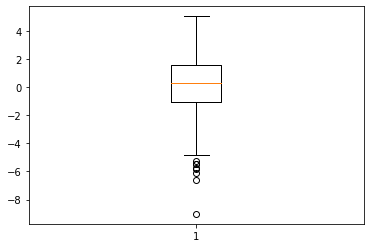

In [69]:
pd_train = train.as_data_frame()
plt.boxplot(pd_train['refactoring_perc_time_taken_log'])

In [70]:
pd_test = test.as_data_frame()
pd_preds['actual_time_taken'] = pd_test['refactoring_perc_time_taken_log']

In [71]:
pd_preds.head()

,predict,actual_time_taken
0,1.185453,-0.144761
1,1.870472,1.565823
2,-0.609796,1.222226
3,1.439150,2.014903
4,-0.709079,-0.370219


In [72]:
pd_preds

,predict,actual_time_taken
0,1.185453,-0.144761
1,1.870472,1.565823
2,-0.609796,1.222226
3,1.439150,2.014903
4,-0.709079,-0.370219
...,...,...
149,-1.709463,-3.832258
150,-0.830488,-7.277040
151,0.174653,0.234138
152,-0.087386,2.046219


{'whiskers': [<matplotlib.lines.Line2D at 0x1d3b60b6208>,
 'caps': [<matplotlib.lines.Line2D at 0x1d3b60b6940>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d3b60b60b8>],
 'medians': [<matplotlib.lines.Line2D at 0x1d3b60bc080>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d3b60bc400>],
 'means': []}

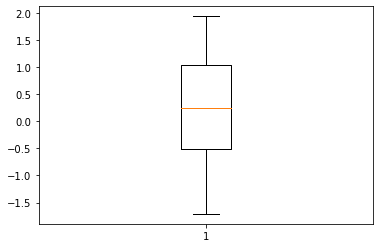

In [73]:
plt.boxplot(pd_preds['predict'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1d3b61939b0>,
 'caps': [<matplotlib.lines.Line2D at 0x1d3b61a2128>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d3b6193860>],
 'medians': [<matplotlib.lines.Line2D at 0x1d3b61a2828>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d3b61a2ba8>],
 'means': []}

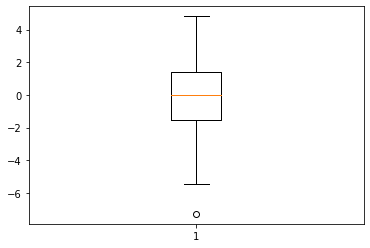

In [74]:
plt.boxplot(pd_preds['actual_time_taken'])

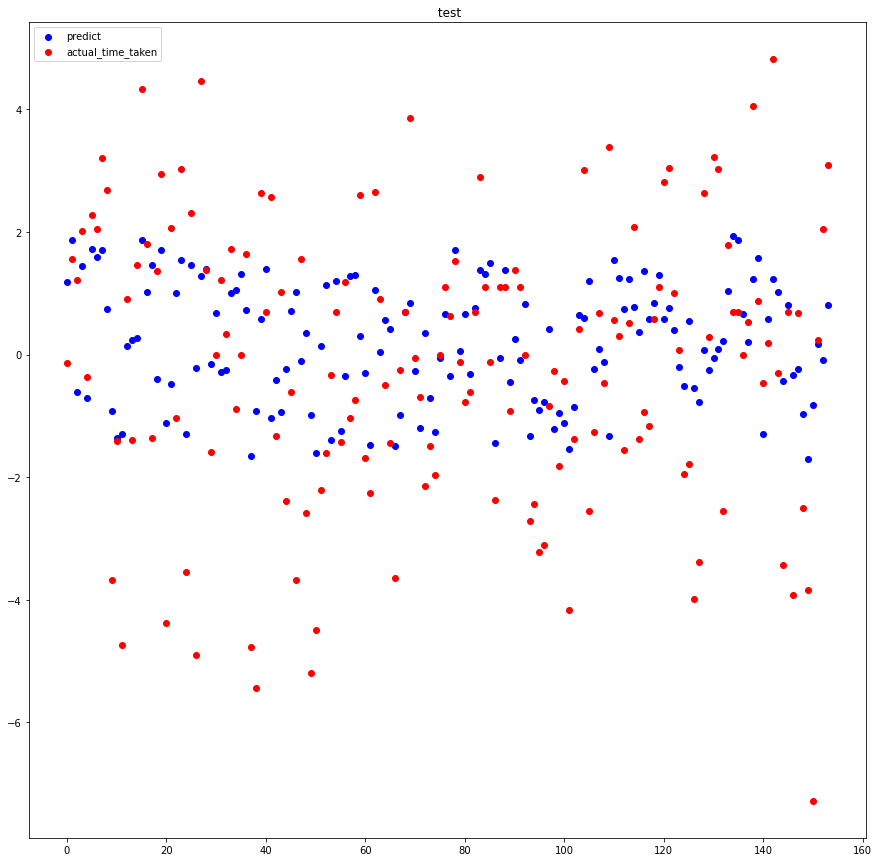

In [87]:
plotGraph(pd_preds['predict'], pd_preds['actual_time_taken'],'predict','actual_time_taken',' test')

In [76]:
visualization = pd_preds[pd_preds['predict'] <= 20]
visualization = pd_preds[pd_preds['actual_time_taken'] <= 20]


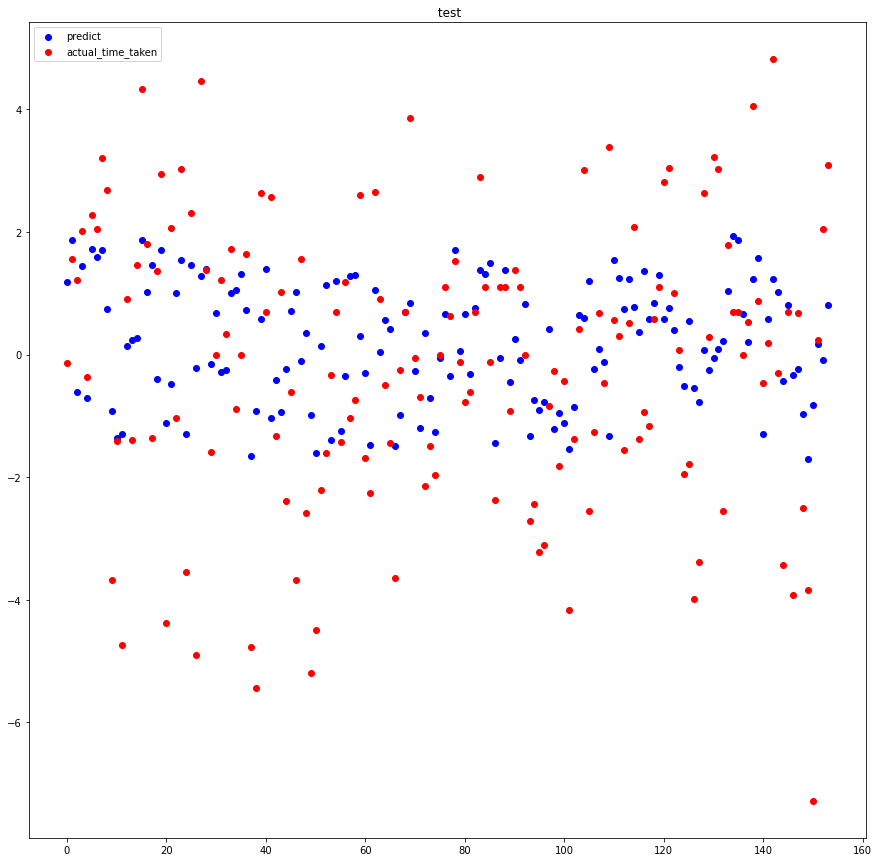

In [77]:
plotGraph(visualization['predict'], visualization['actual_time_taken'],'predict','actual_time_taken',' test')

Text(0.5, 1.0, 'Actual vs Predicted')

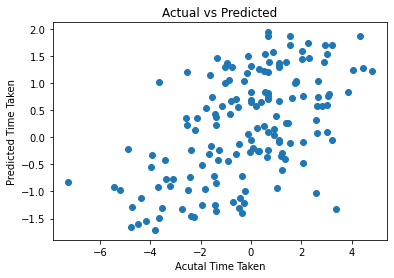

In [86]:
import matplotlib.pyplot as plt
plt.scatter(pd_preds['actual_time_taken'], pd_preds['predict'])
#plt.plot([-3, 3], [-3, 3], color = 'black', linewidth = 2)
plt.xlabel('Acutal Time Taken')
plt.ylabel('Predicted Time Taken')
plt.title('Actual vs Predicted')

In [95]:
# save the model
model_path = h2o.save_model(model=model, path="models/EffortEstimationModelv3", force=True)

Documentation at the following

https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/explanation/_explain.html

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

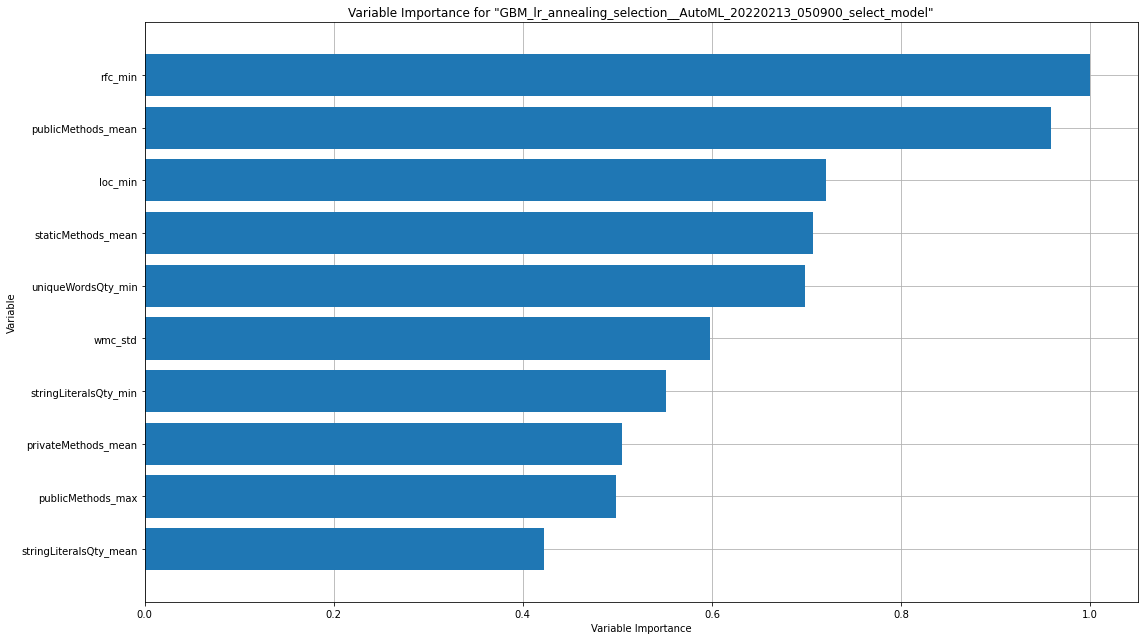

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

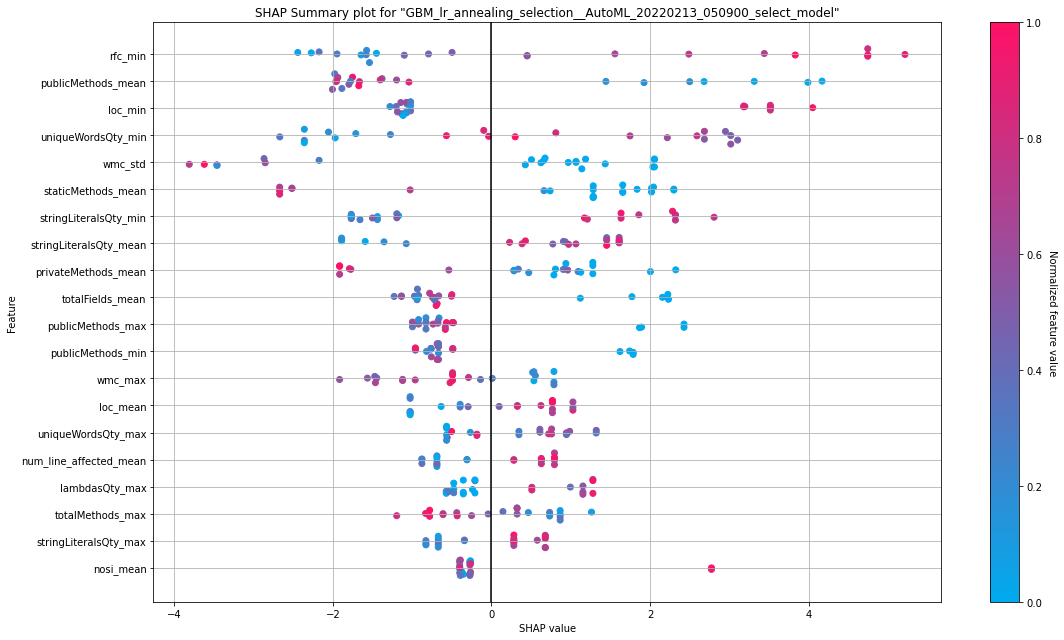

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

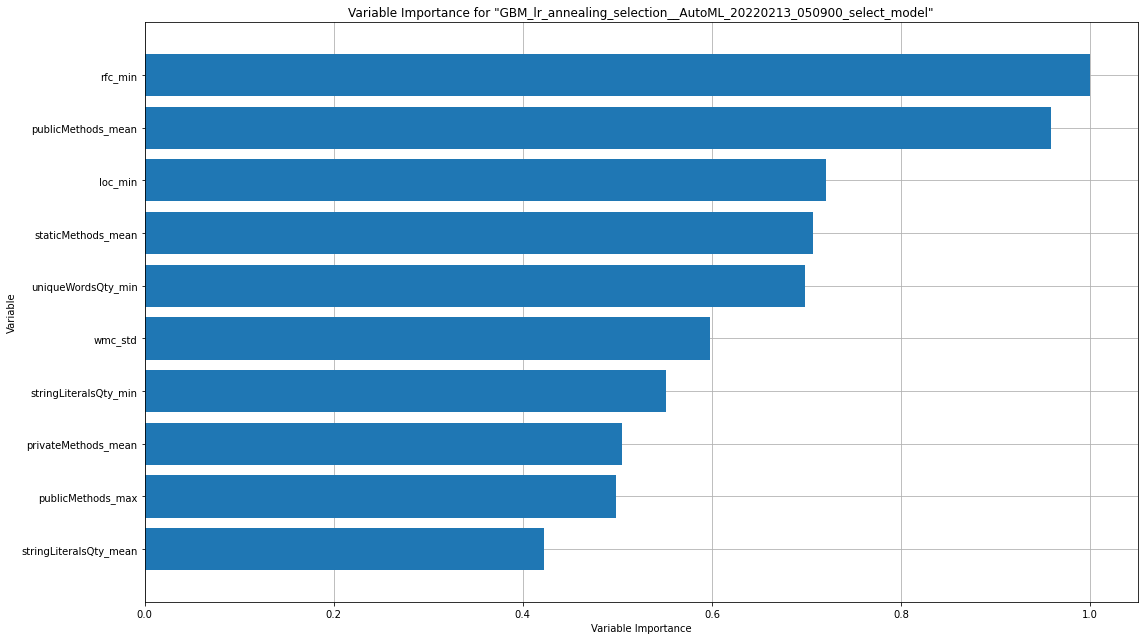

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

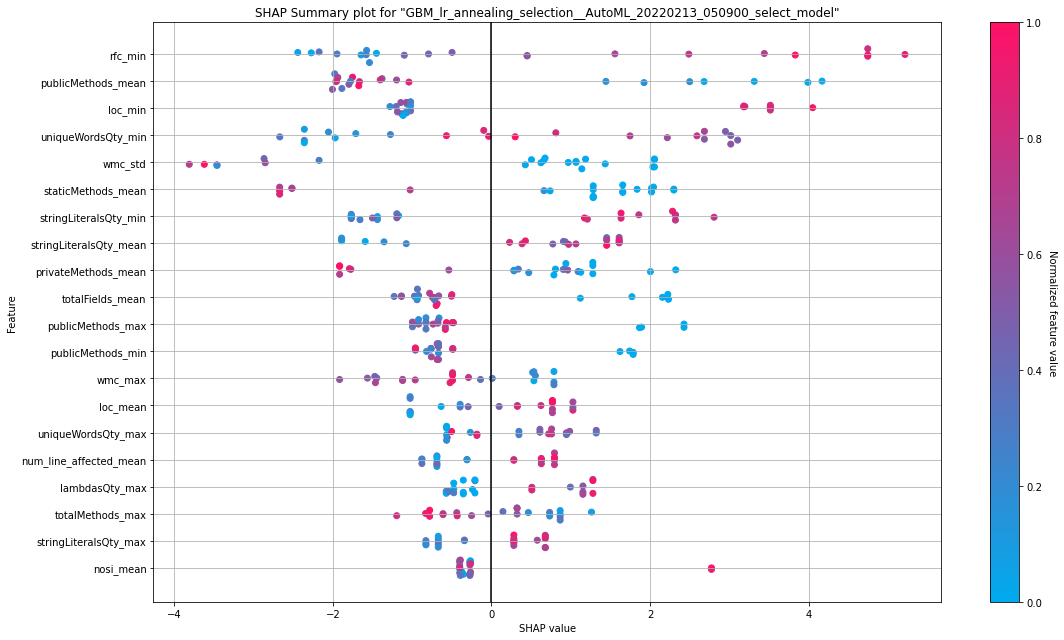

In [71]:
aml.explain(test, include_explanations=["varimp",'shap_summary'])

In [63]:
## Test calling of model

model_path = "models/EffortEstimationModelv3/Log_Regression_GBM_grid__1_AutoML_20220228_154246_model_3"
model = h2o.load_model(model_path)

In [ ]:
preds_read_model = model.predict(test)
pd_preds_read_model = preds_read_model.as_data_frame()
pd_preds_read_model['actual_time_taken'] = pd_test['refactoring_perc_time_taken']

In [ ]:
plotGraph(pd_preds_read_model['predict'], pd_preds_read_model['actual_time_taken'],'predict','actual_time_taken',' test')

In [ ]:
#aml.explain_row(test, row_index=0)

In [ ]:
#h2o.shutdown()